# DS em Produção

## O CFO da empresa fez uma reunião com todos os Gerentes de Loja e pediu para que cada um deles trouxesse uma previsão diária das próximas 6 semanas de vendas.
## Depois dessa reunião, todos os gerentes entraram em contato com você, requisitando uma previsão de vendas de sua loja.

# 0.0 IMPORTS

In [27]:
import math
import numpy as np
import pandas as pd
import inflection
import seaborn as sns
import xgboost as xgb
import random
import pickle
import datetime
from scipy import stats as ss
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
import matplotlib.gridspec as gridspec
from boruta import BorutaPy


## 0.1. Helper Functions

In [28]:
def jupyter_settings():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set(style='white')

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n) / (min( kcorr-1, rcorr-1 )))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y) * 100

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    mpe = mean_percentage_error(y, yhat)

    return pd.DataFrame({'Model Name': model_name, 
                         'MAE': mae, 
                         'MAPE': mape, 
                         'RMSE': rmse,}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    # Kfold
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKFold Number: {k}')

        # Start and End date for Validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # Filtering Dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # Training and Validation dataset
        # Training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # Validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        yhat = m.predict(xvalidation)

        # Performace
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # Store Performace of each KFold Iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame(
        {'Model Name': model_name,
        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str), 
        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str), 
        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

jupyter_settings()

## 0.2. Loading Data

In [29]:
df_sales_raw = pd.read_csv('./data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('./data/store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Passo 01 - Descrição dos Dados

## 1.0. DESCRIÇÃO DOS DADOS

In [30]:
df1 = df_raw.copy()
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns

In [31]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# Rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [32]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [33]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [34]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [35]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
123920,156,6,2015-04-11,2612,308,1,0,0,0,a,a,2020.0,2.0,2011.0,1,14.0,2011.0,"Mar,Jun,Sept,Dec"


## 1.5. Fillout NA

In [36]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'Jun', 6: 'Jul', 7: 'Aug', 8: 'Set', 9: 'Oct', 10: 'Sep', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'] = df1['promo_interval'].fillna(0)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

In [37]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [38]:
# competition_open_since_month
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

# competition_open_since_year
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# promo2_since_week 
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

# promo2_since_year
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7.0. Descriptive Statistcal

In [39]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 1.7.1. Numerical Attributes

In [40]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.160546,0.0,0.367112,1.849324,1.420002


C:\Users\Andre\AppData\Local\Temp\ipykernel_7248\2867122750.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'], kde=False)


<Axes: xlabel='competition_distance'>

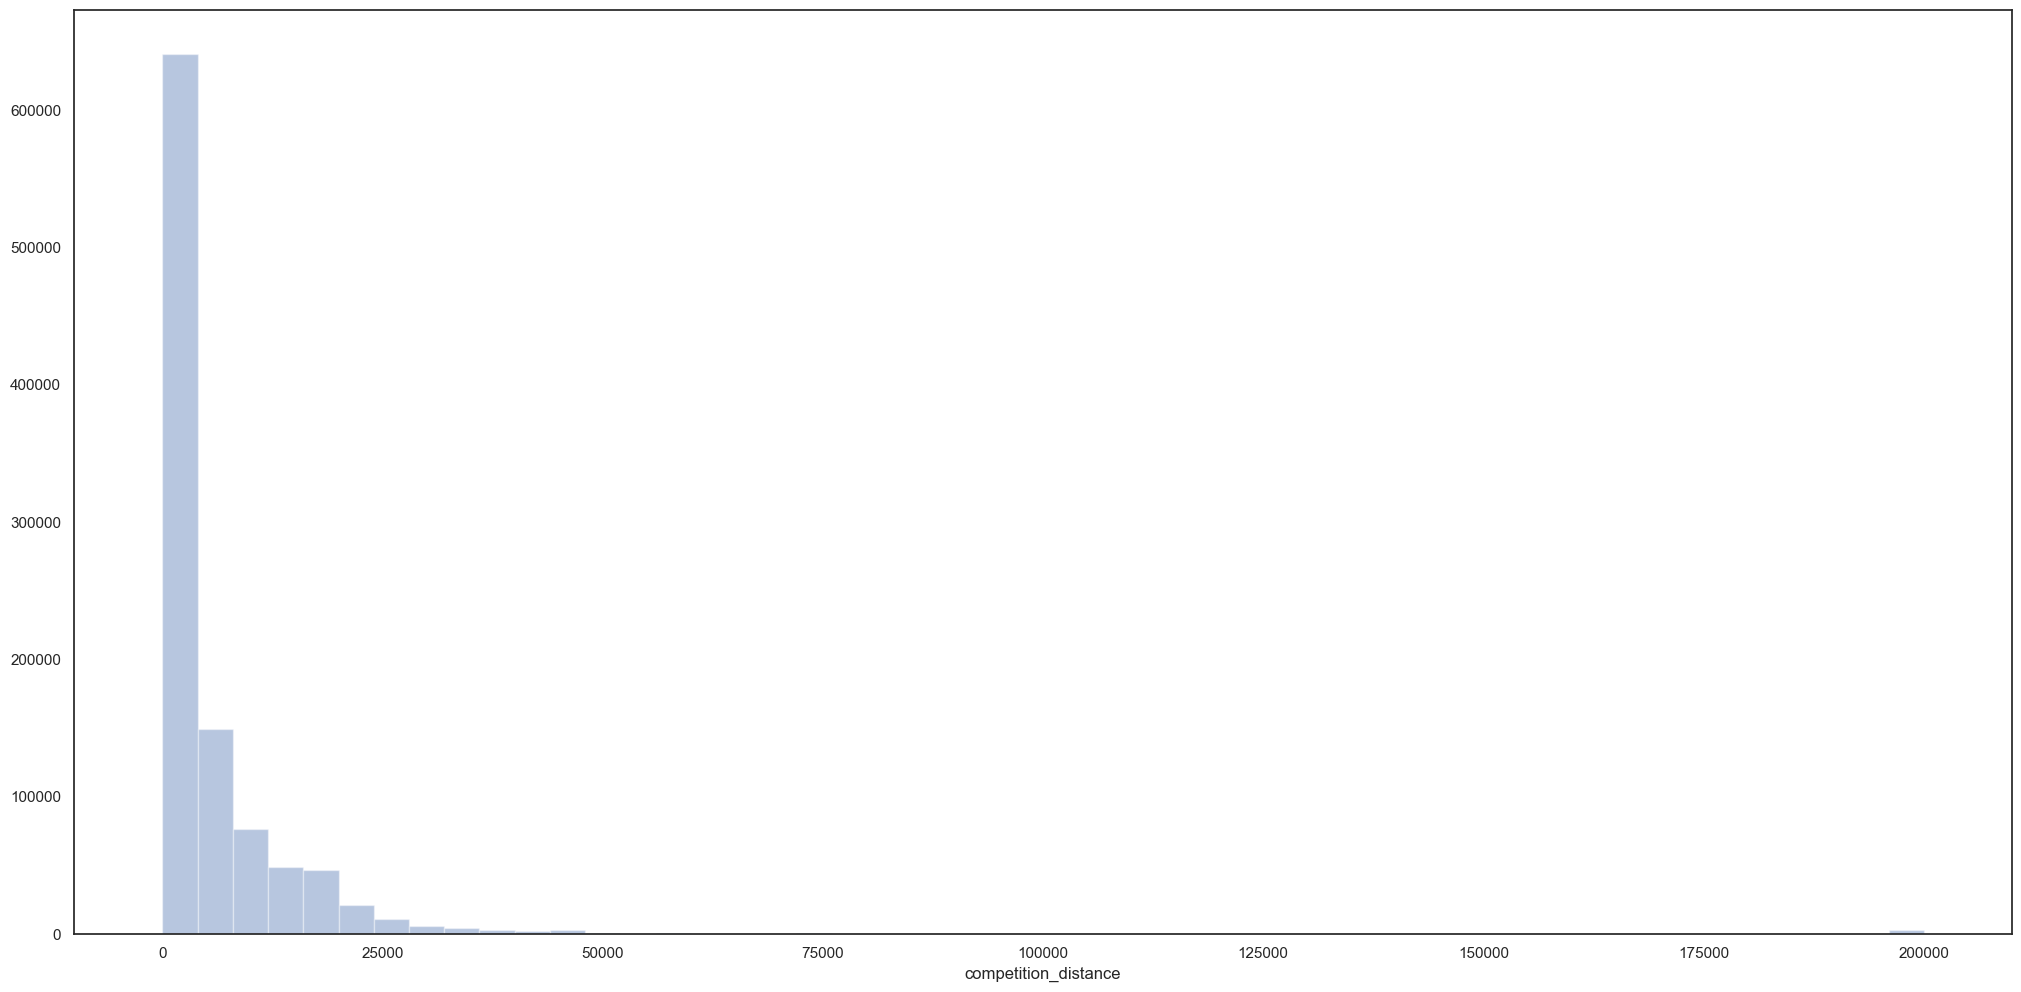

In [41]:
sns.distplot(df1['competition_distance'], kde=False)

## 1.7.2. Categorical Attributes

In [42]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

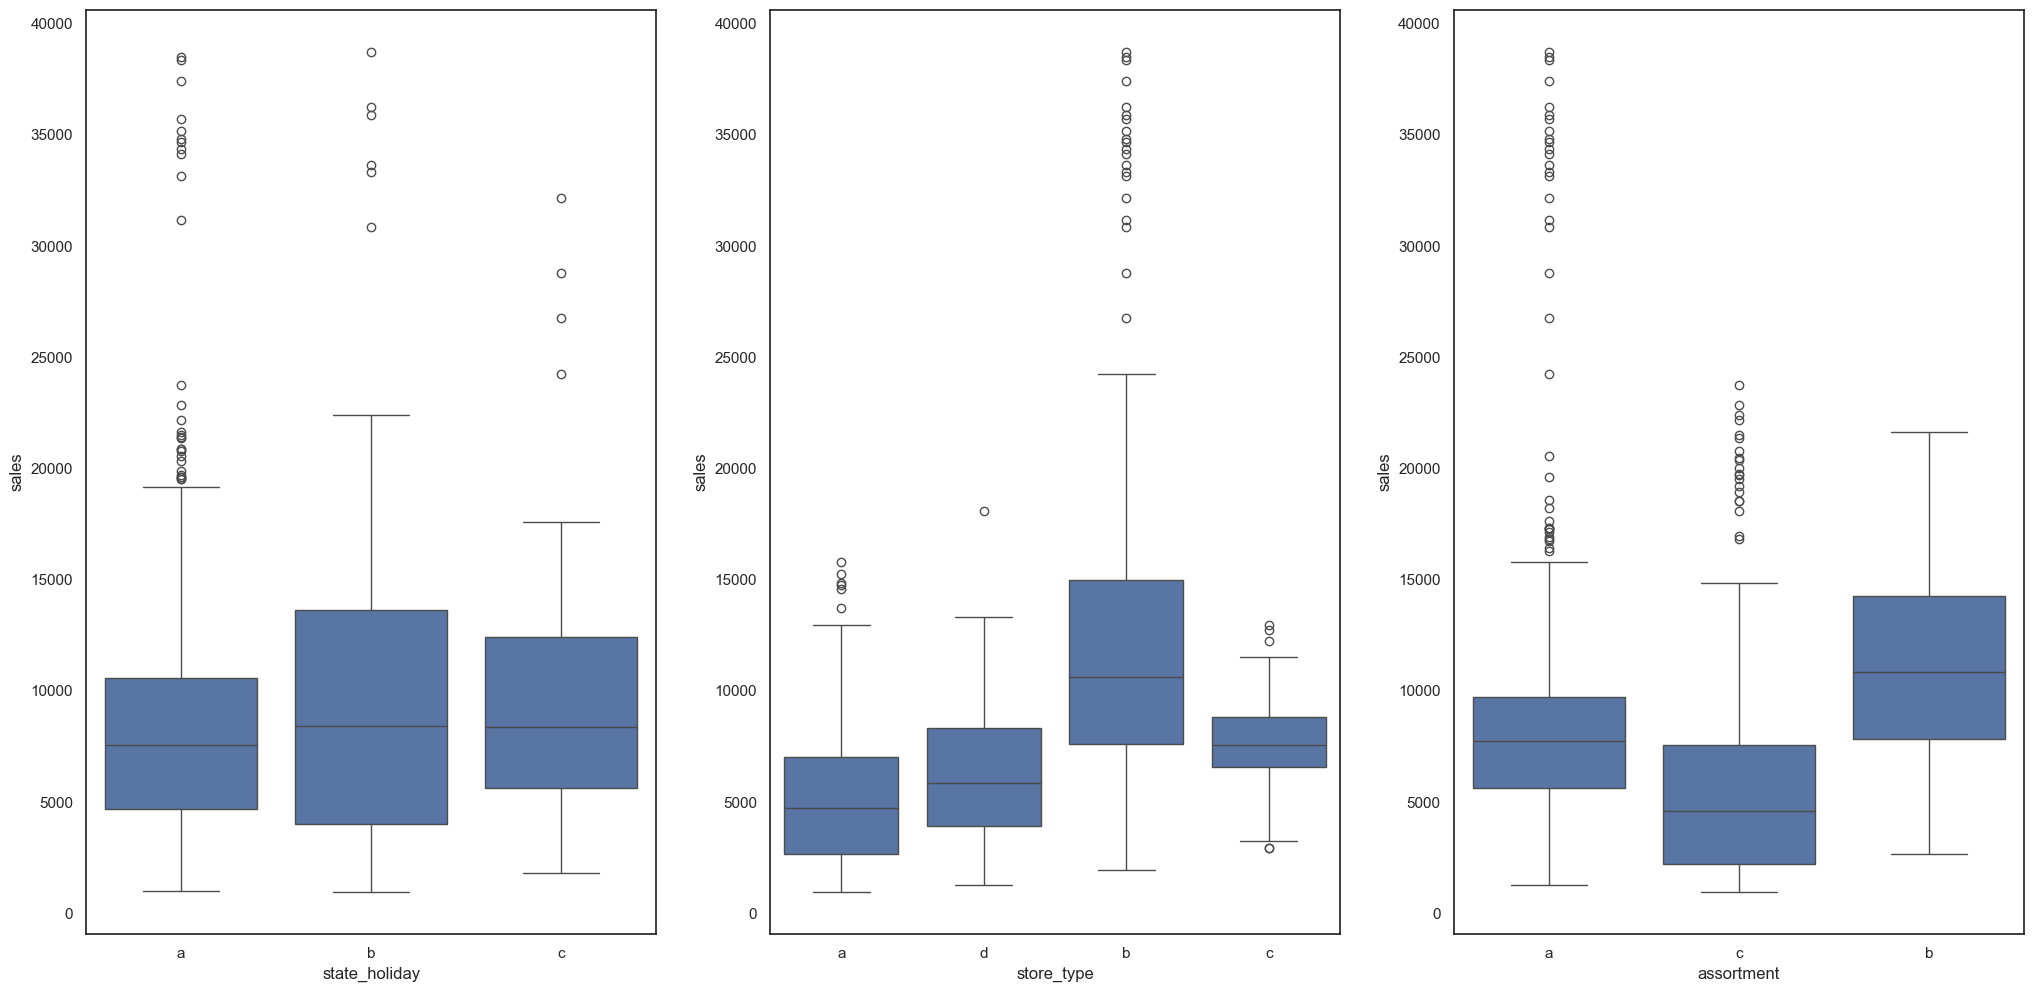

In [43]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)

# 2.0 Passo 02 - Fearture Engineering

In [44]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

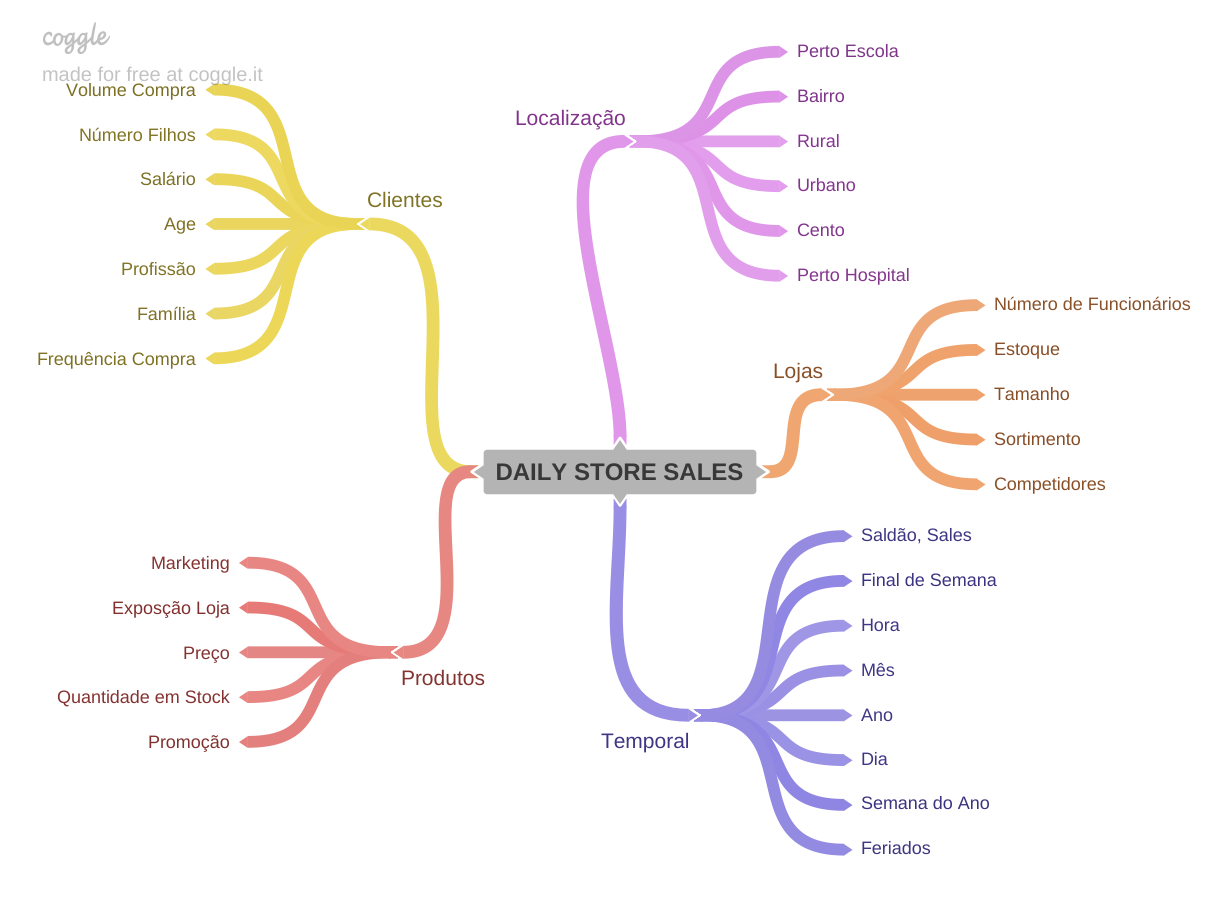

In [45]:
Image('./img/MindMapHypothesis.png')

## 2.1. Criação das Hipóteses

### 2.1.1. Hipóteses Loja

**1**. Lojas com número maior de funcionários deveriam vender mais.

**2**. Lojas com maior capacidade de estoque deveriam vender mais.

**3**. Lojas com maior porte deveriam vender mais.

**4**. Lojas com maior sortimentos deveriam vender mais.

**5**. Lojas com competidores mais próximos deveriam vender menos.

**6**. Lojas com competidores à mais tempo deveriam vendem mais.


### 2.1.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.
 
**2.** Lojas com maior exposição de produto deveriam vender mais.
 
**3.** Lojas com produtos com preço menor deveriam vender mais.
 
**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
 
**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.
 
**7.** Lojas com mais dias de promoção deveriam vender mais.
 
**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.2 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Fearture Engineering

In [46]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'] )/7).apply(lambda x: x.days ).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 Passo 03 - Filtragem de Variáveis

In [47]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [48]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [49]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Passo 04 - Análise Exploratória de Dados

In [50]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1 Response Variable

C:\Users\Andre\AppData\Local\Temp\ipykernel_7248\3439622439.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales'], kde=False);


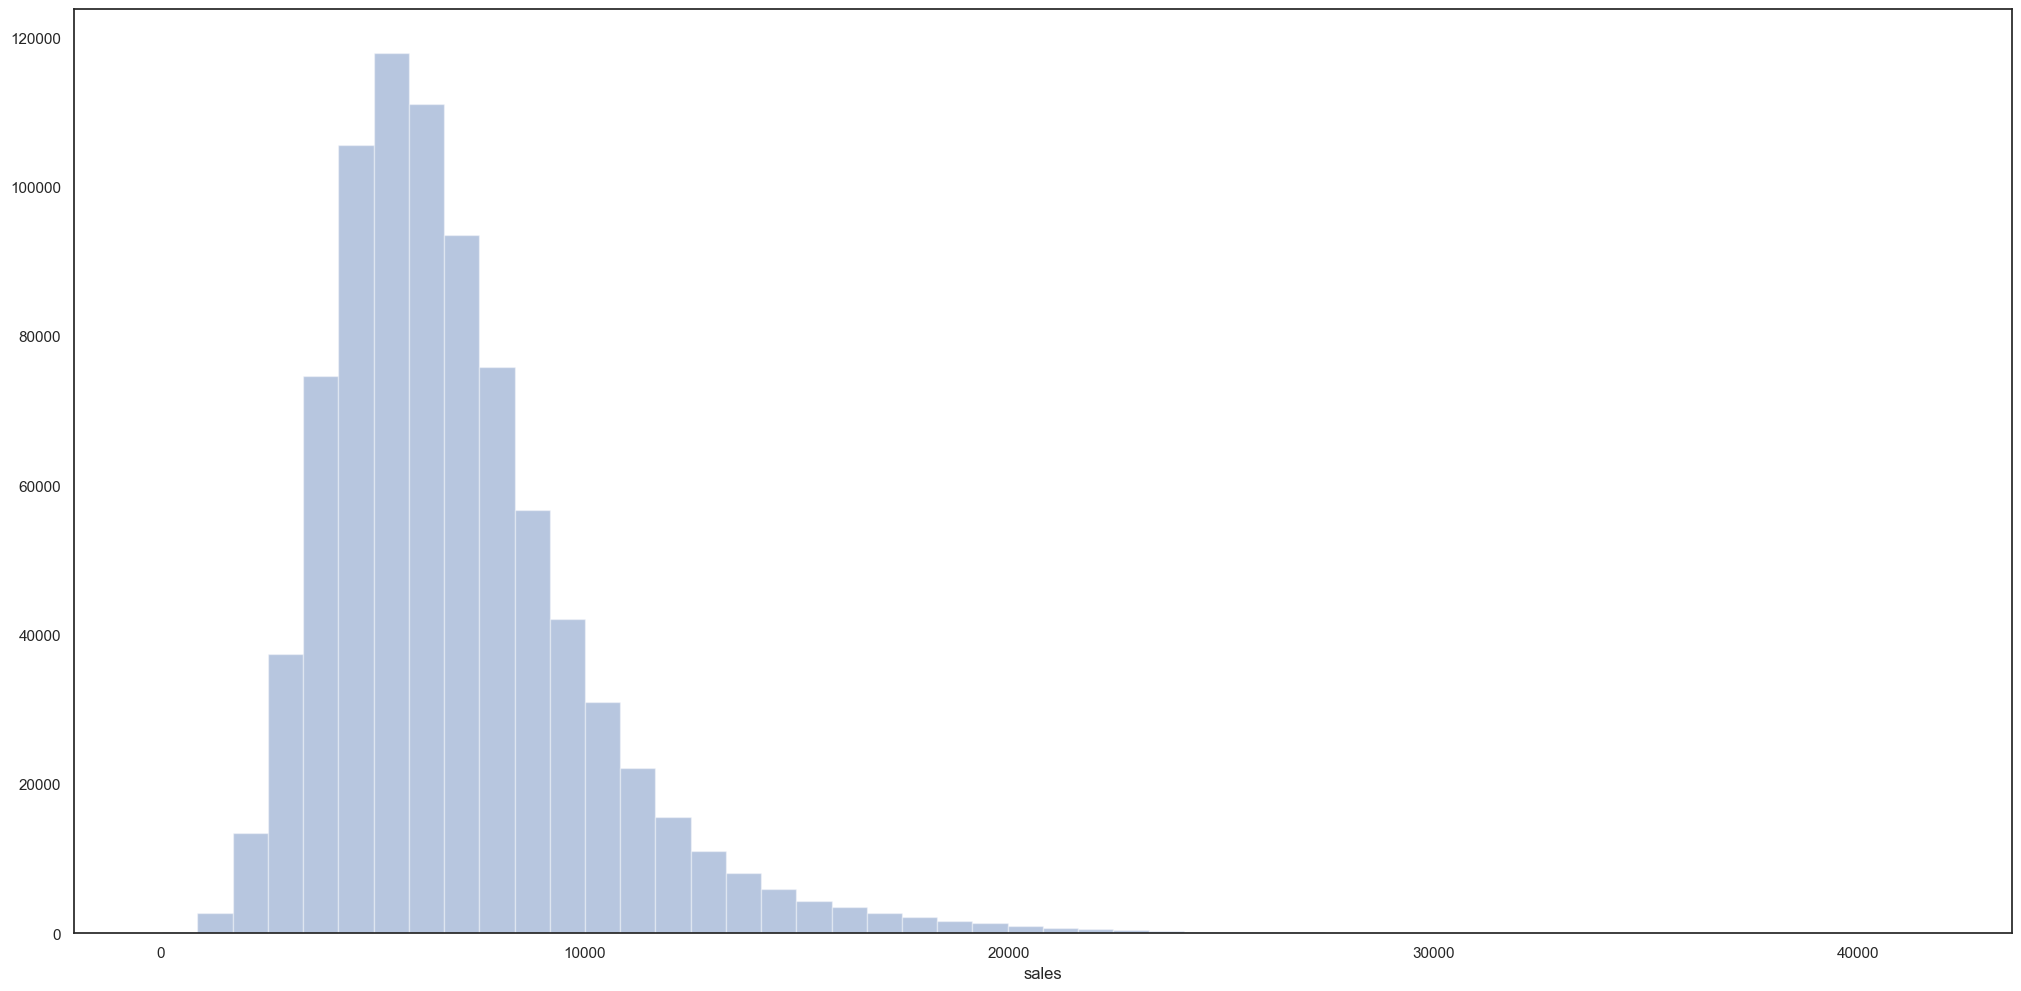

In [51]:
sns.distplot(df4['sales'], kde=False);

### 4.1.2 Numerical Variale

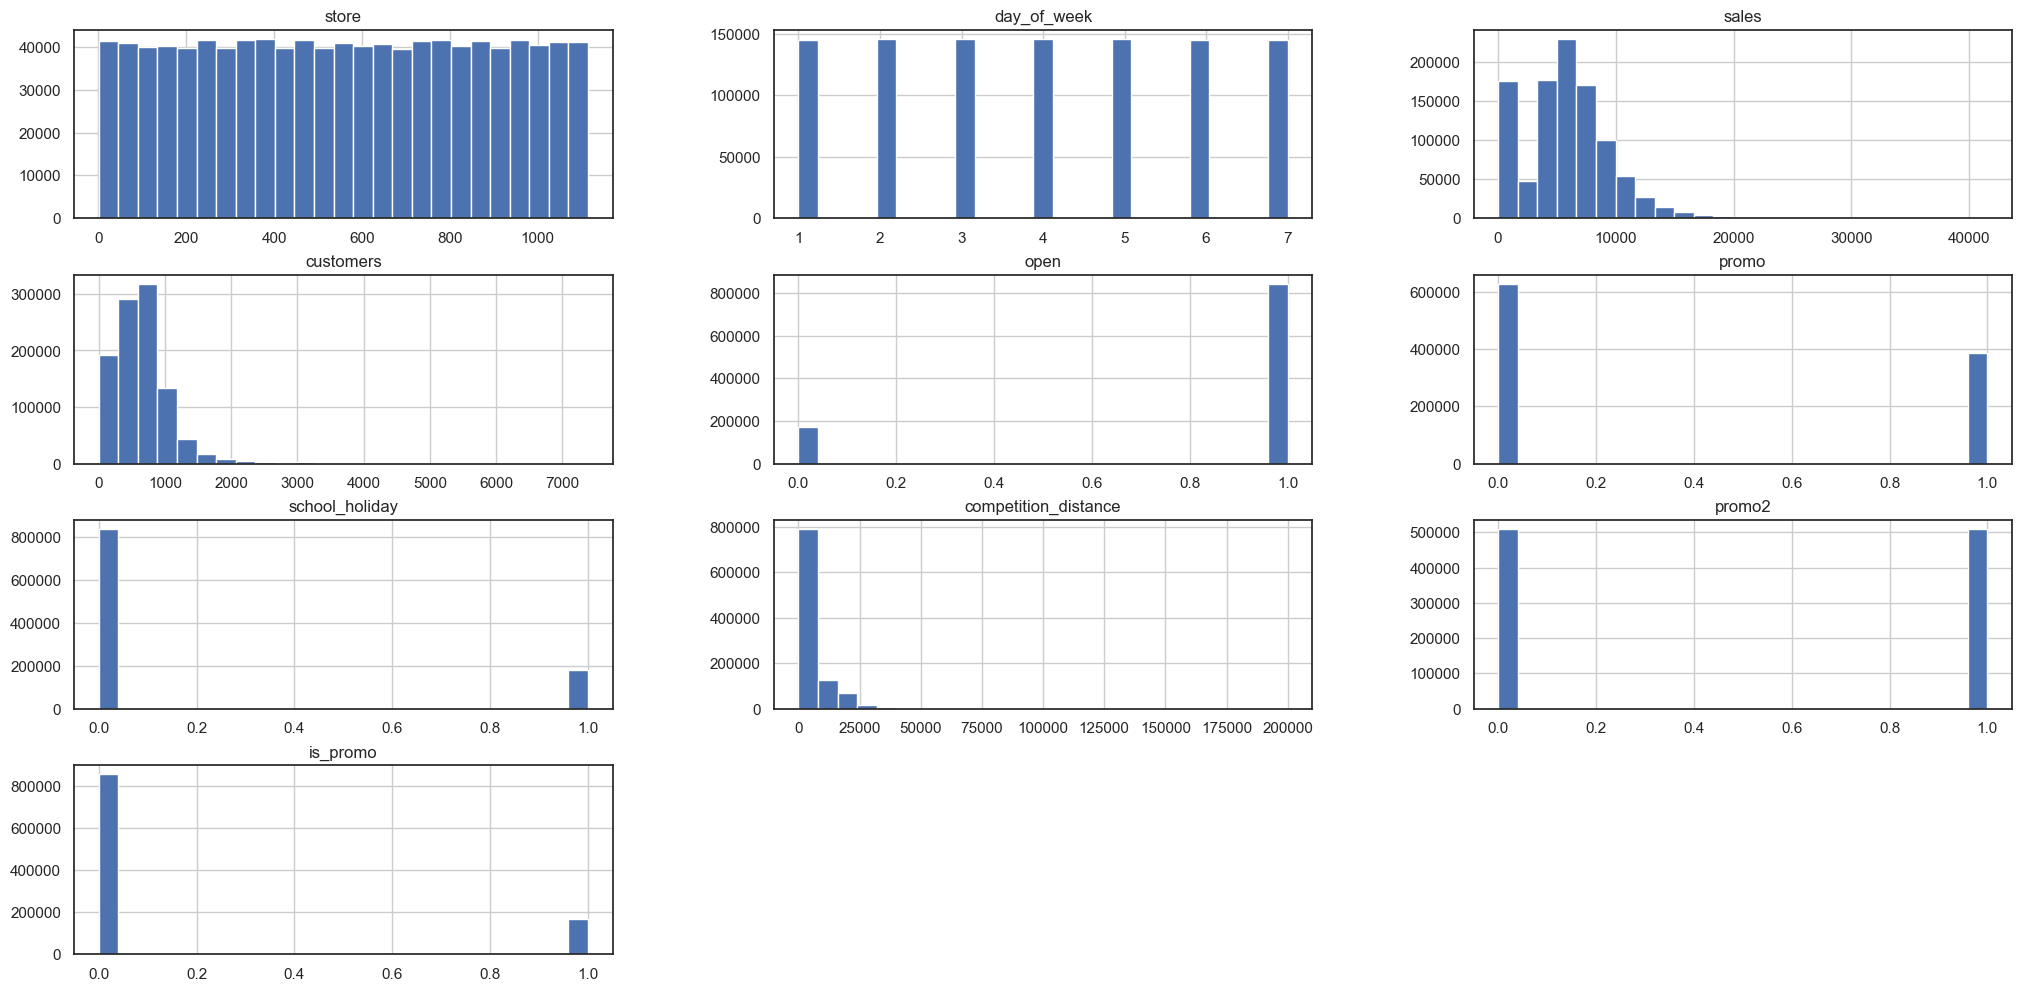

In [52]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

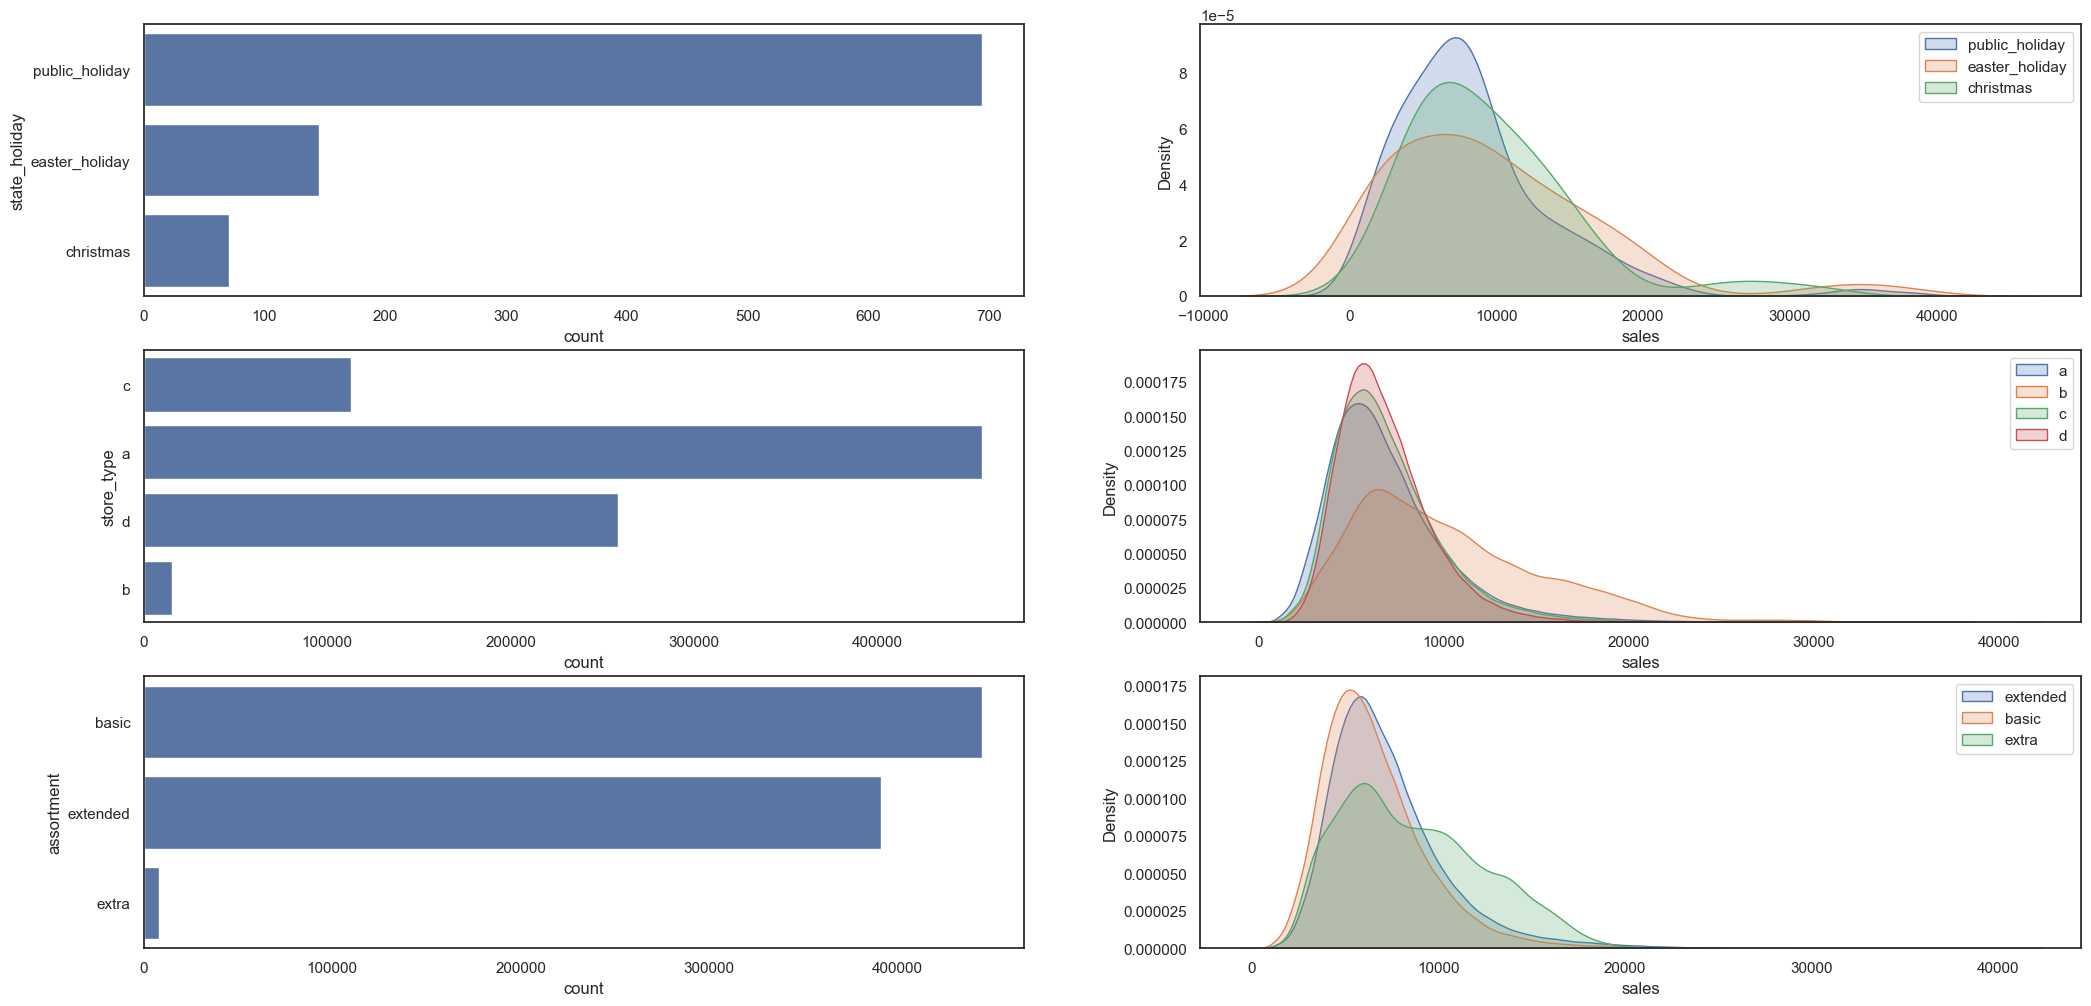

In [53]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
plt.legend()

# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)
plt.legend()

## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

<Axes: xlabel='year_week'>

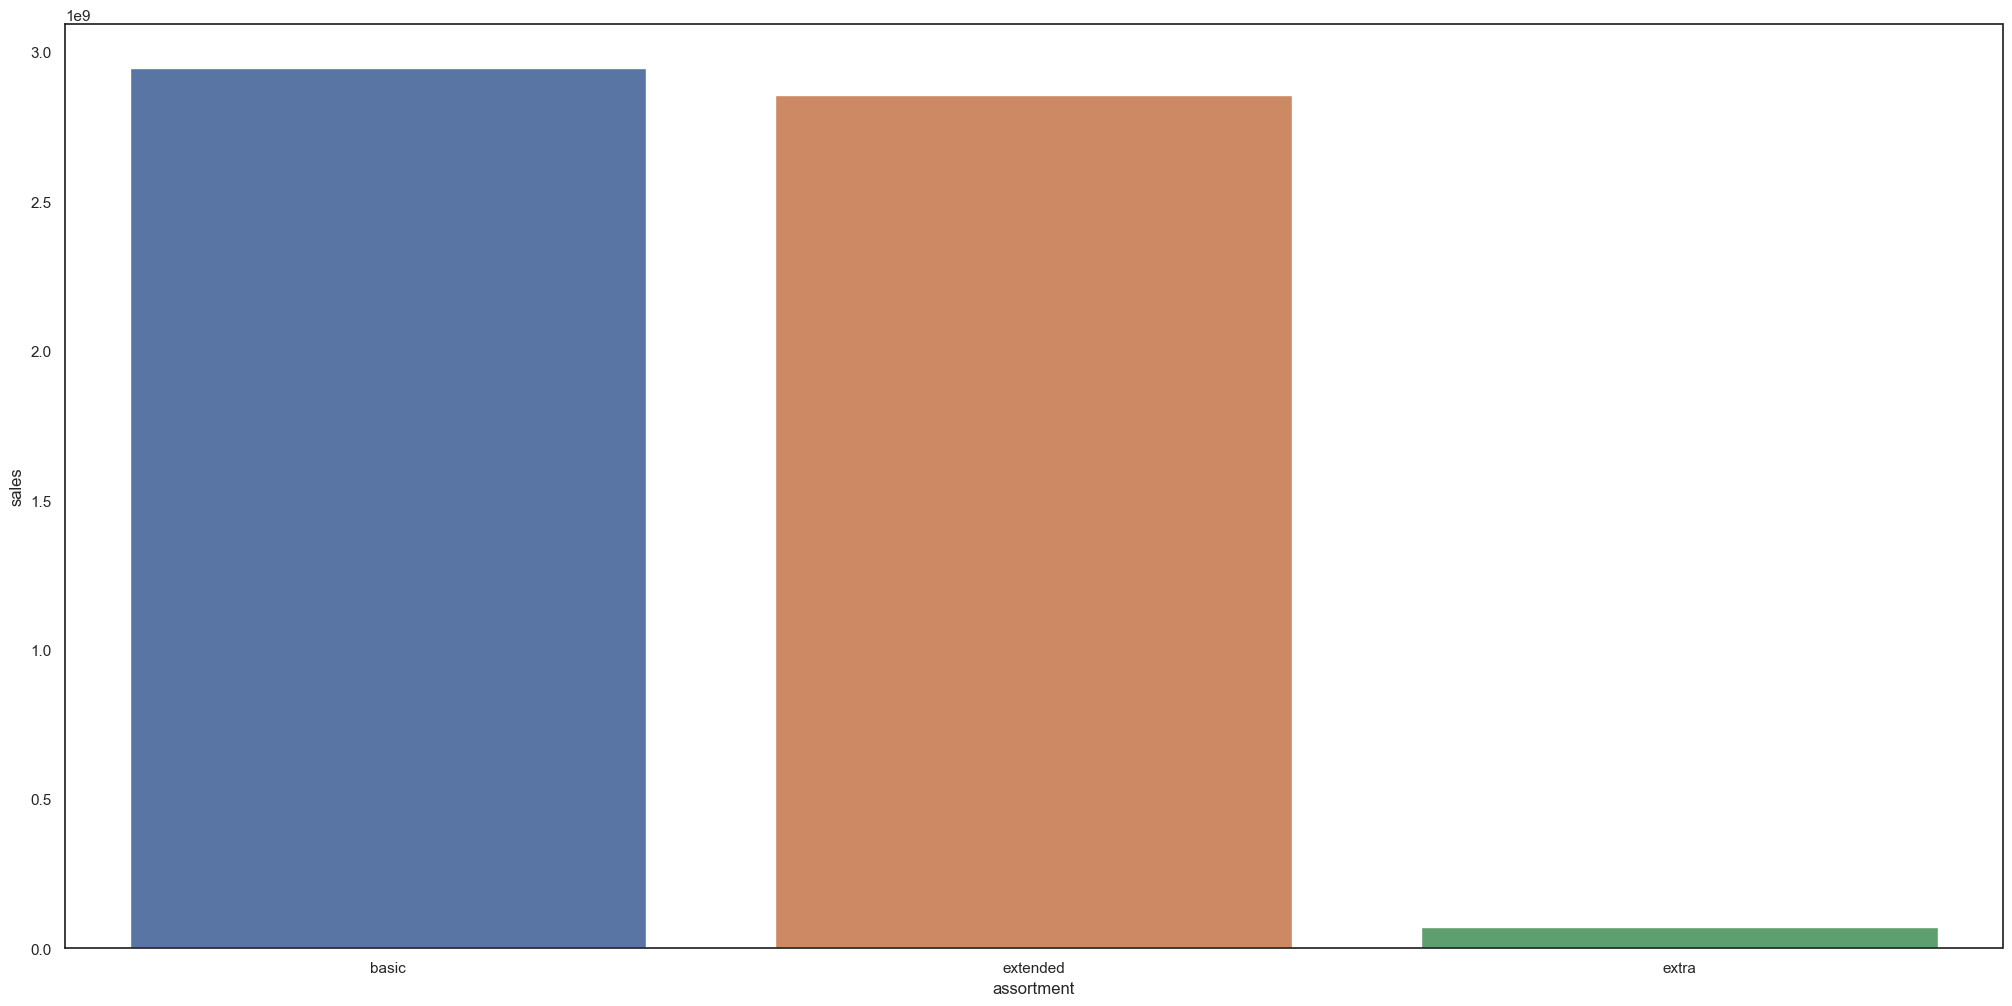

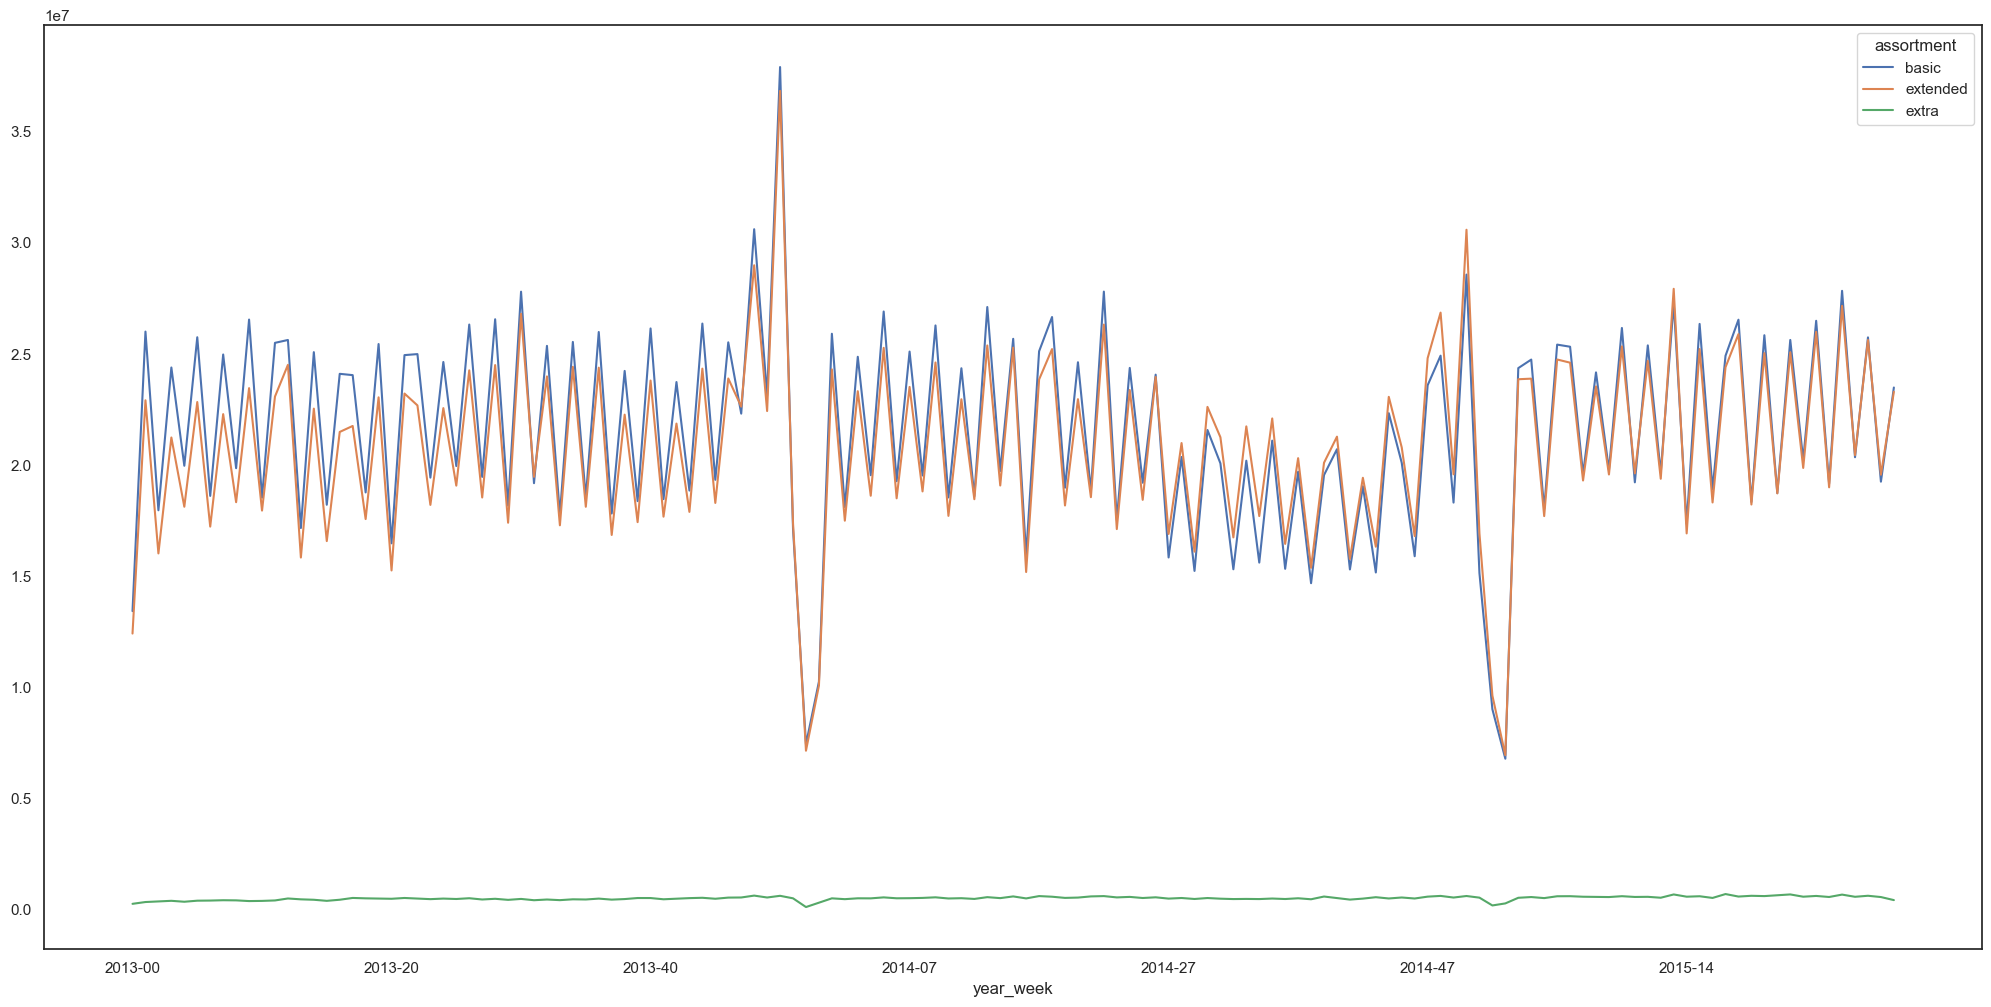

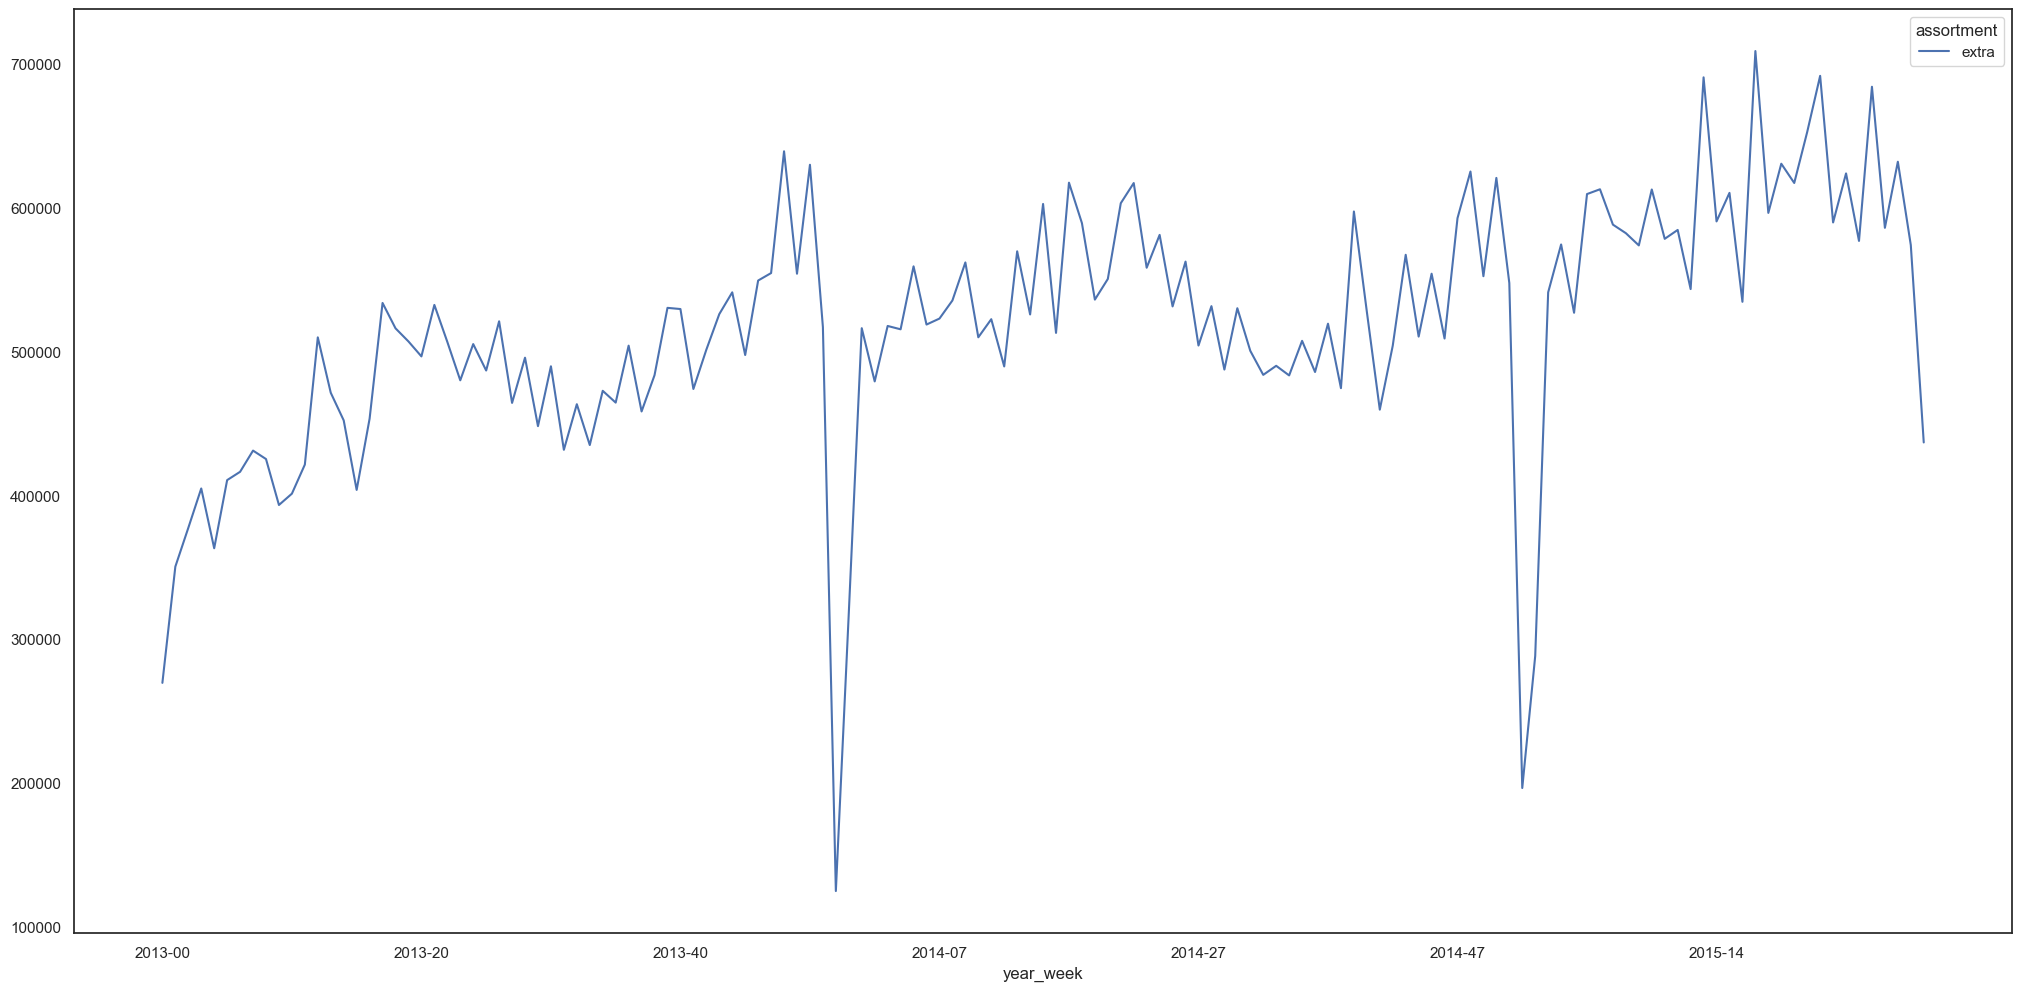

In [54]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1, hue='assortment');

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vemdem MAIS.

<Axes: >

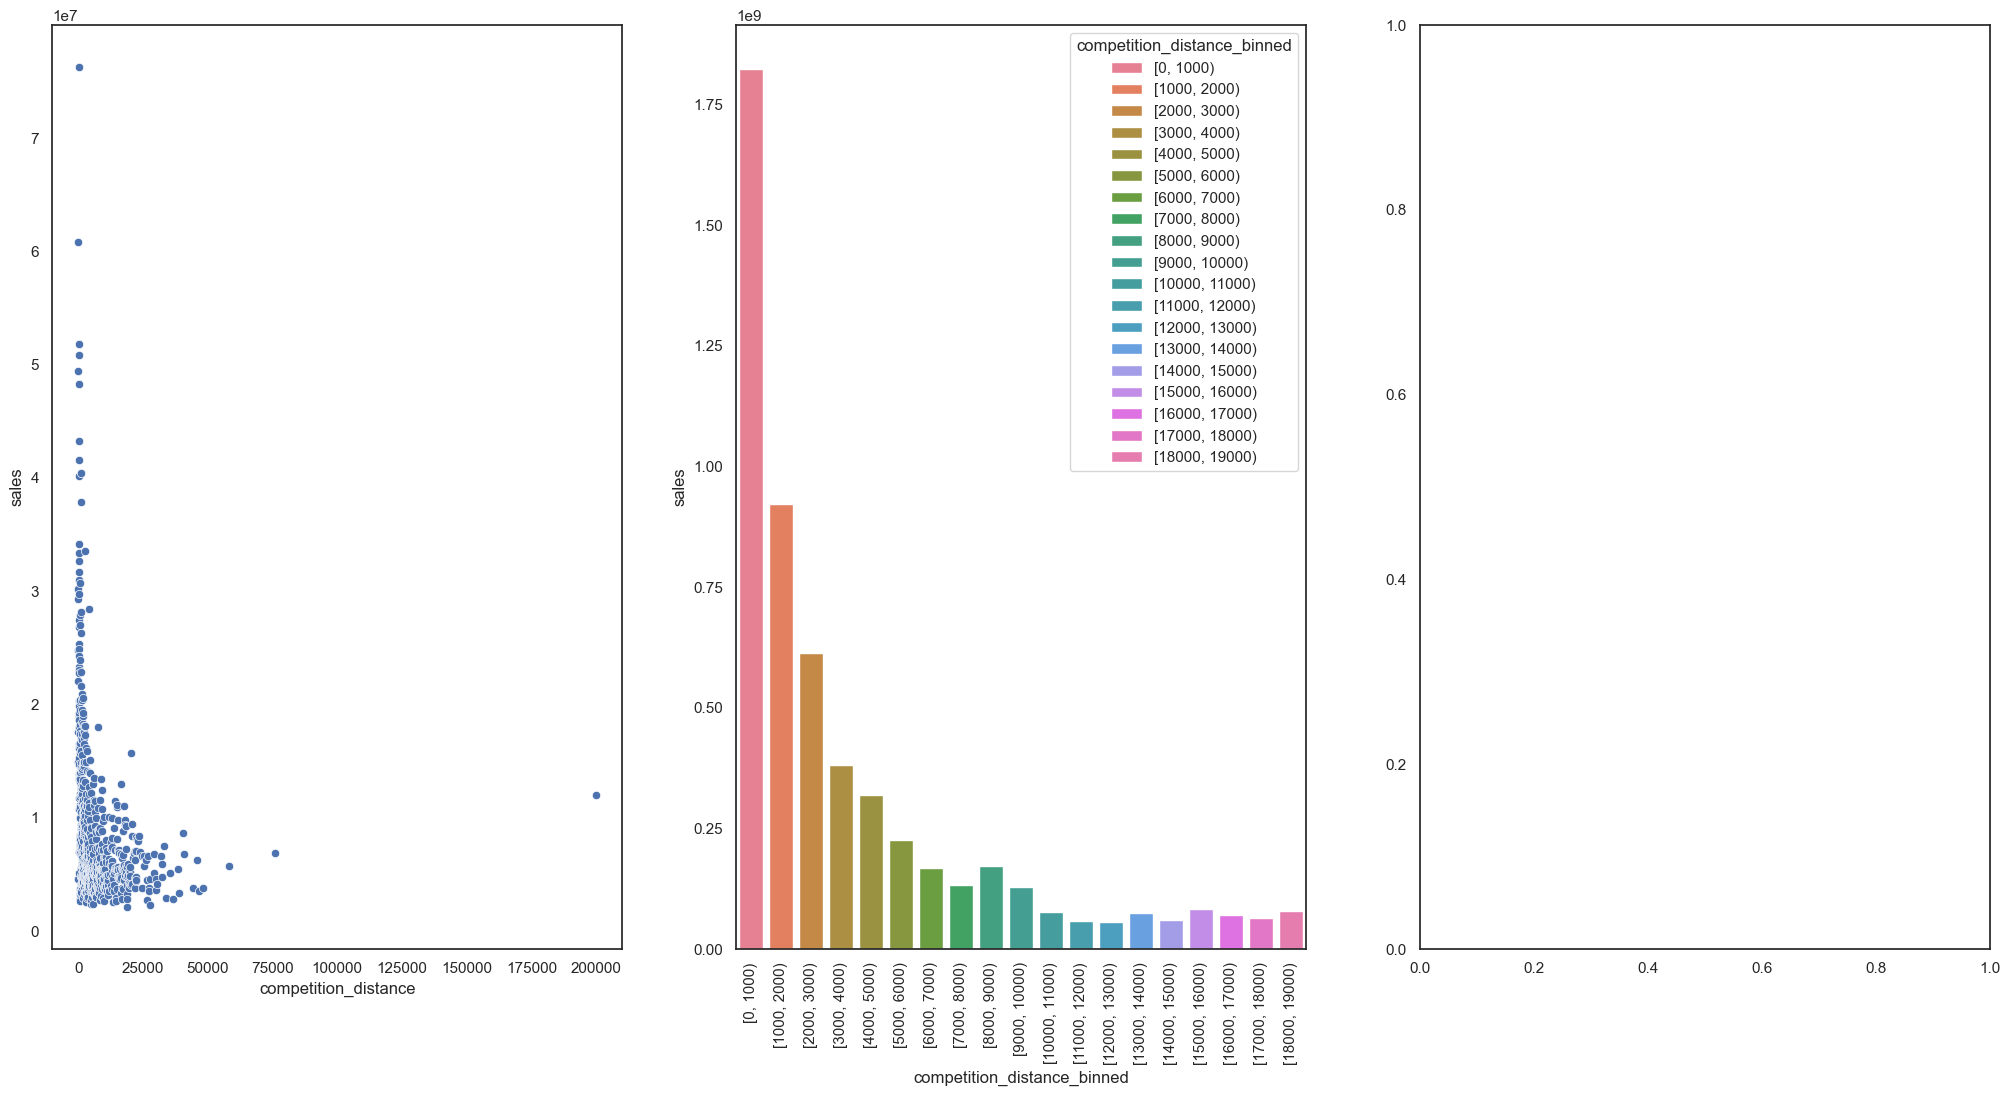

In [55]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))  # Corrigindo os intervalos dos bins
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins, right=False)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned', observed=False).sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2, hue='competition_distance_binned')
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
#sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

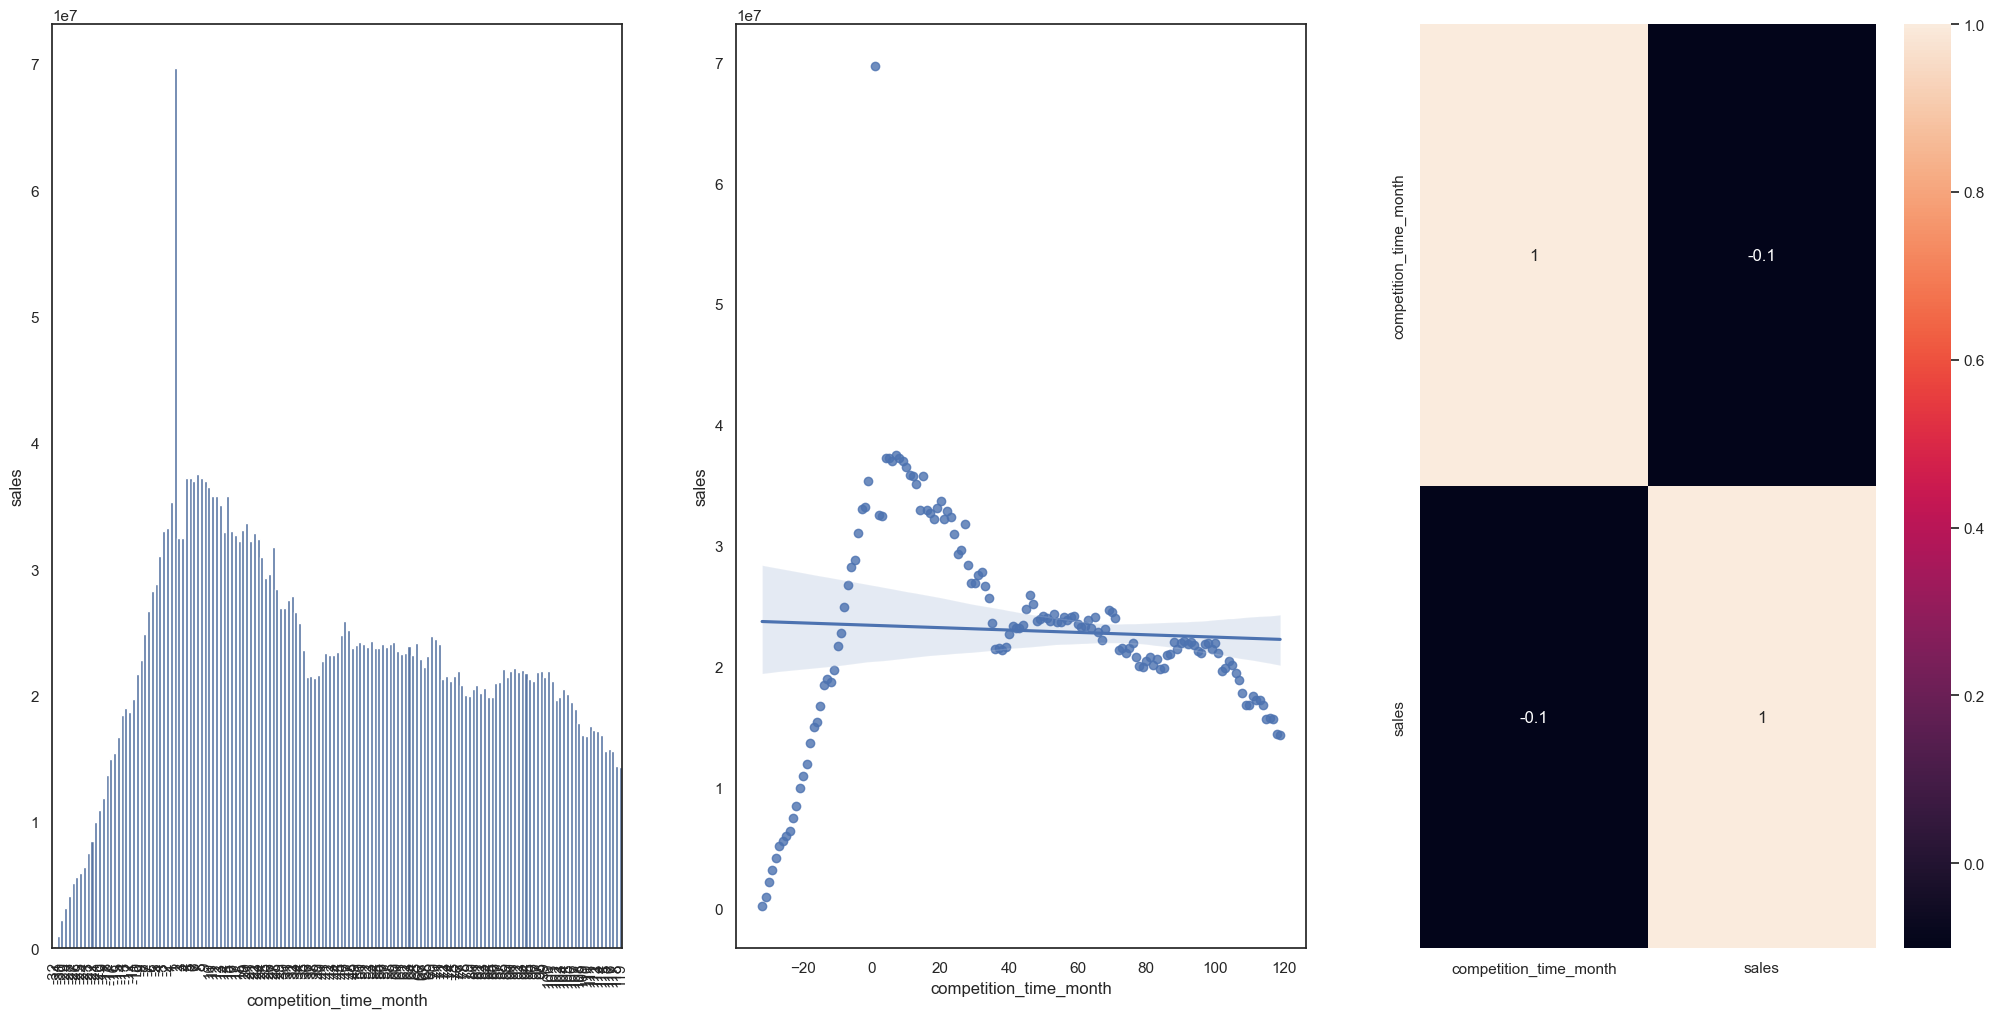

In [56]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas por mas tempo vendem menos, depois de um certo periodo de promoção

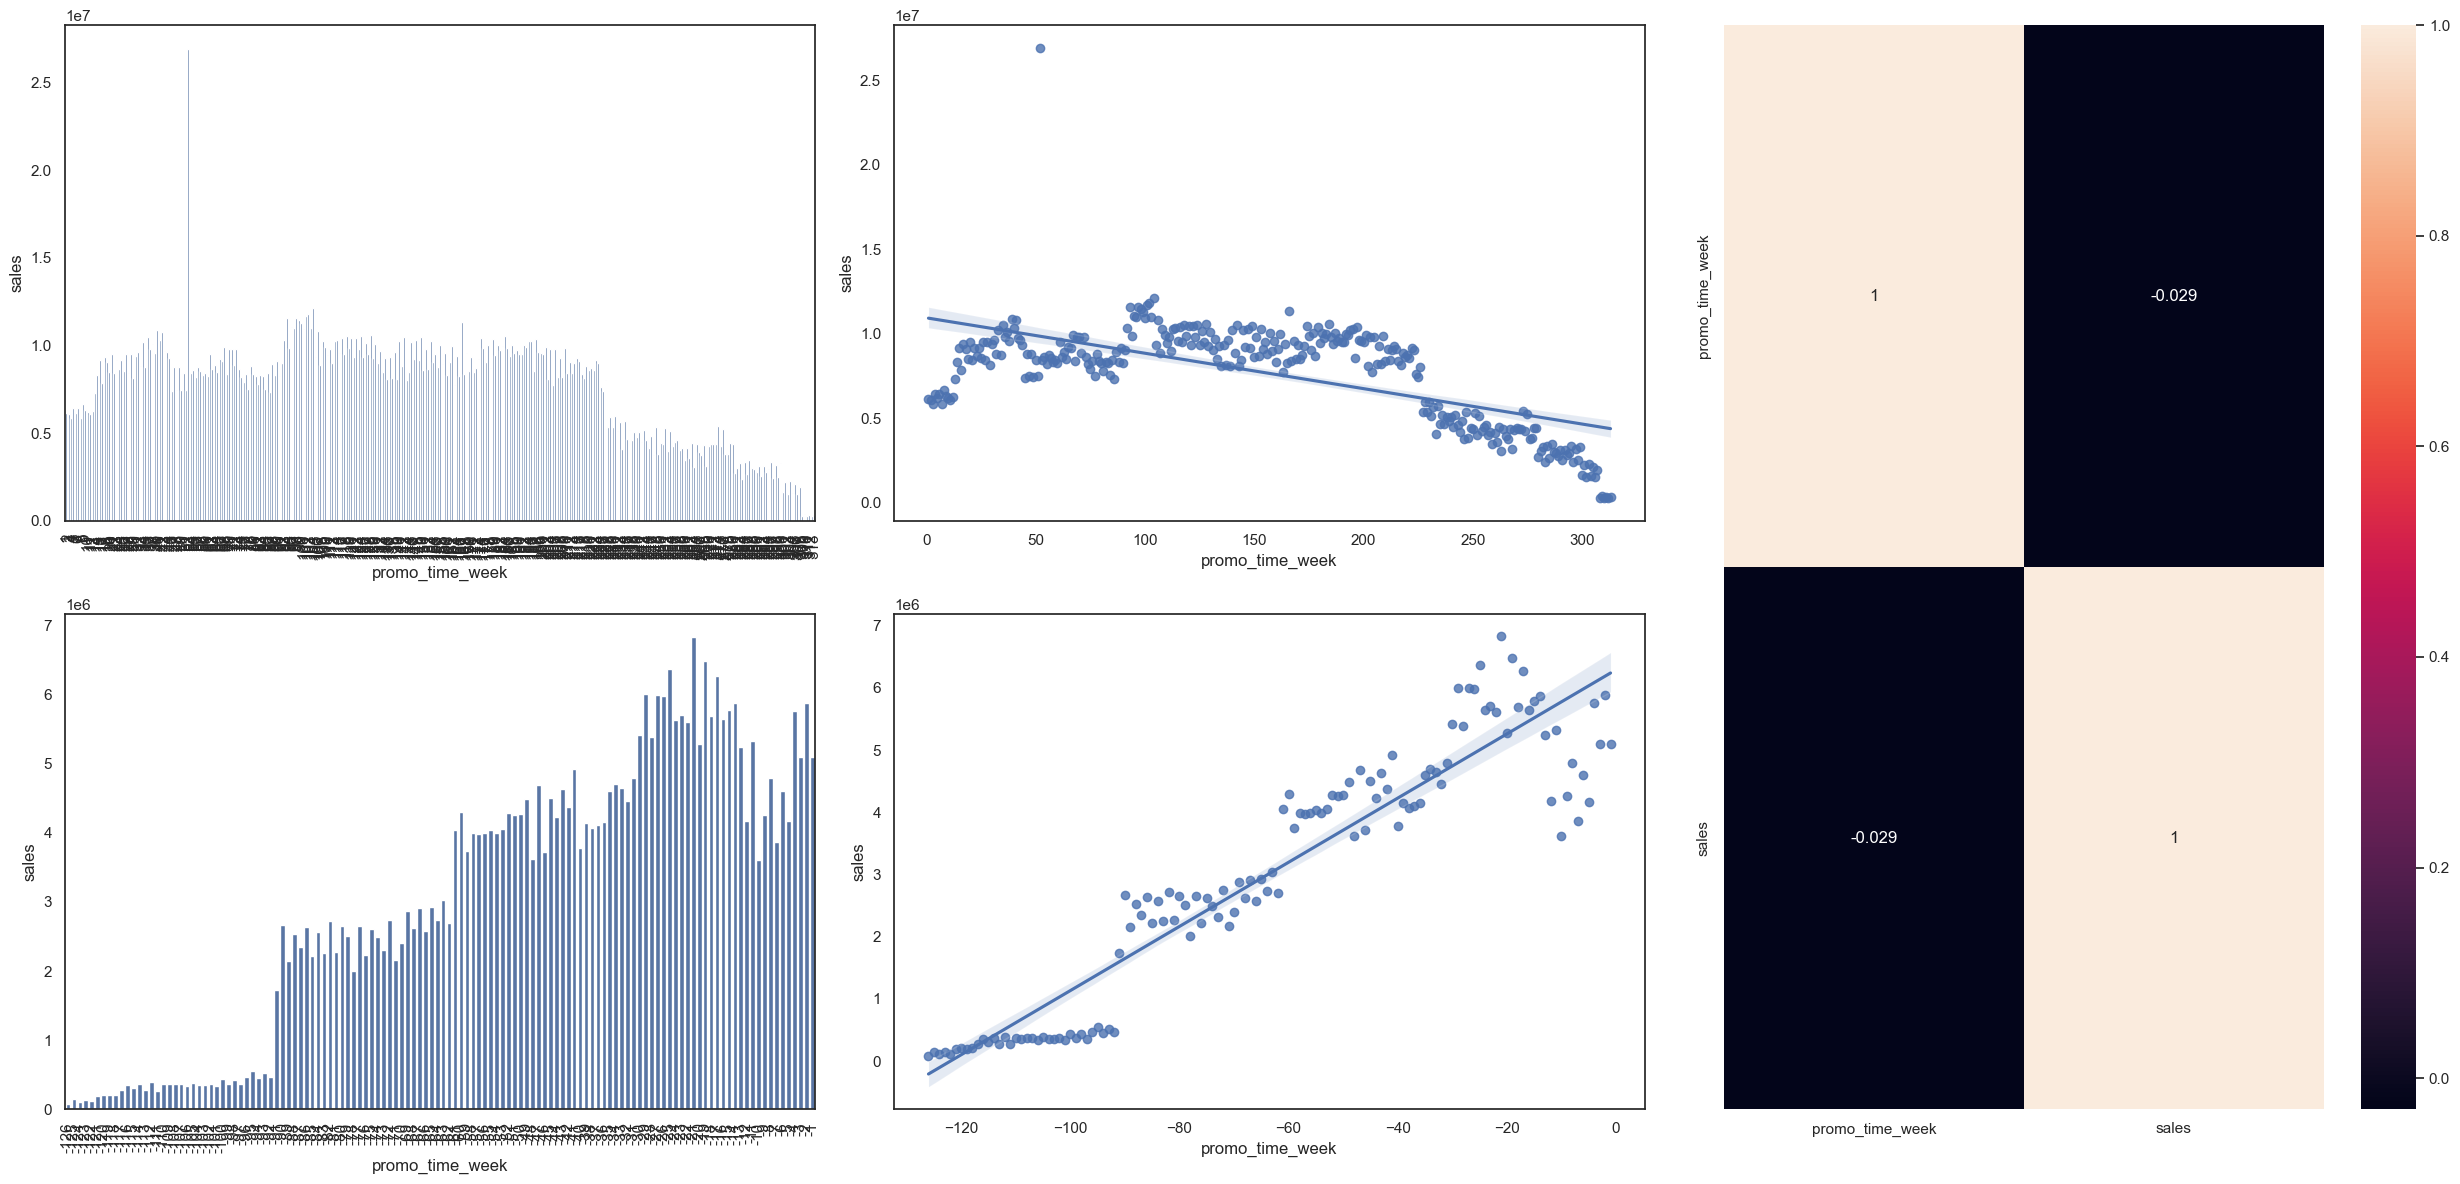

In [57]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.tight_layout()

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H7.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem menos.

In [58]:
(df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().
 sort_values(by='sales', ascending=True))

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


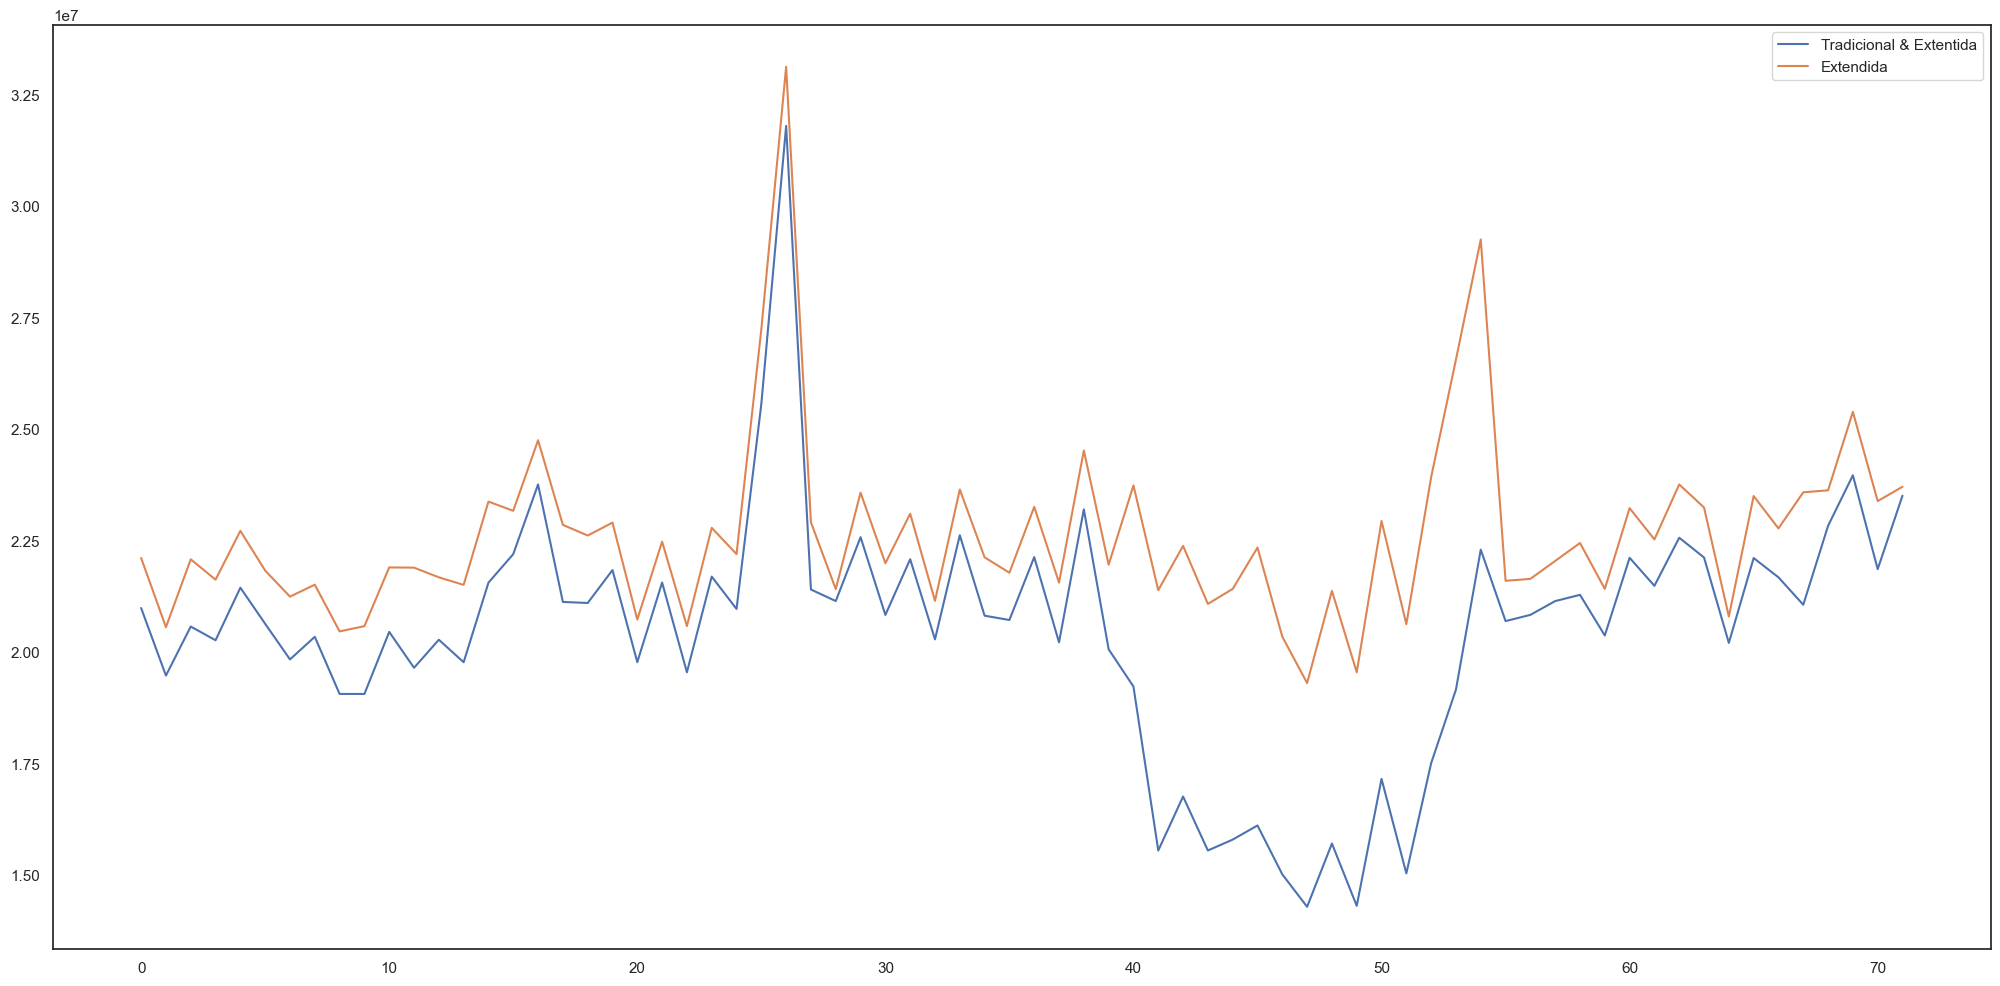

In [59]:
aux1 = (df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].
        groupby('year_week').sum().reset_index())
ax = aux1.plot()

aux2 = (df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].
         groupby('year_week').sum().reset_index())
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extentida', 'Extendida'])


### **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertar durante o feriado do Natal vendem menos.

<Axes: xlabel='year', ylabel='sales'>

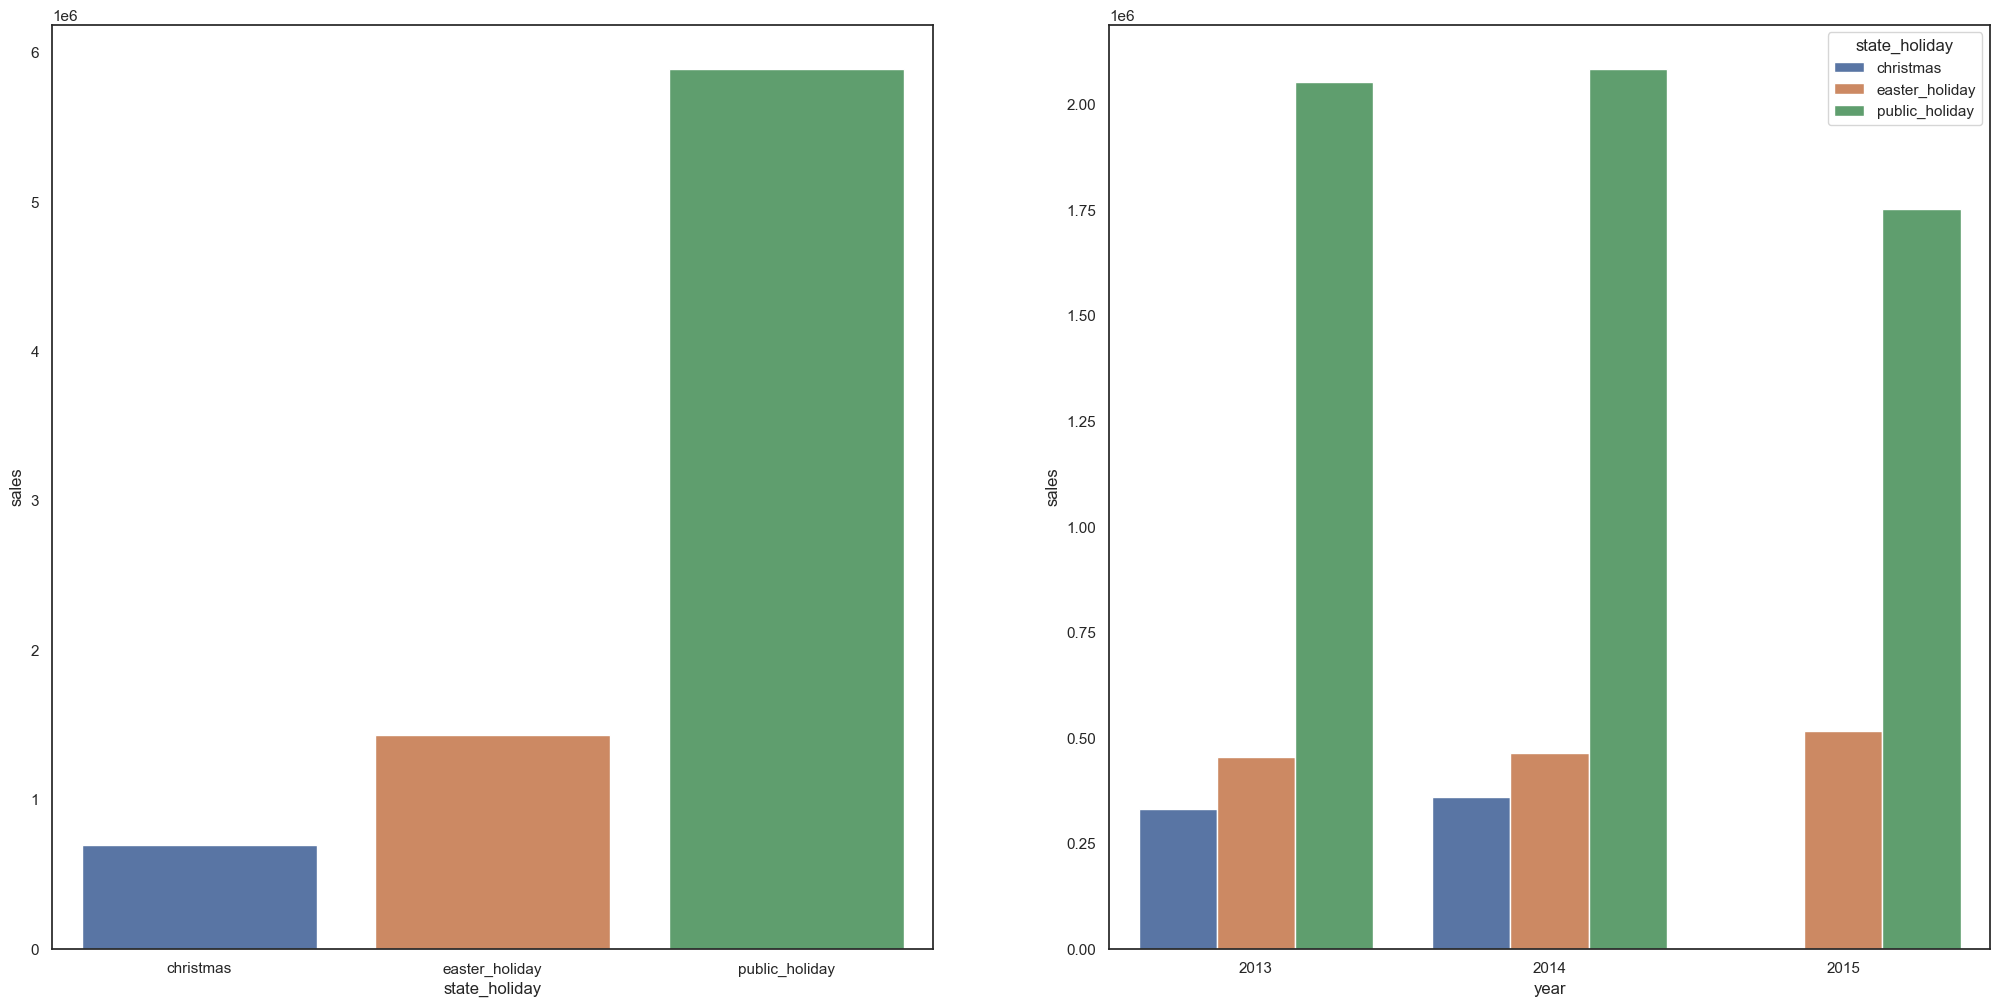

In [60]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1, hue='state_holiday');

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)

### **H9.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos.

<Axes: >

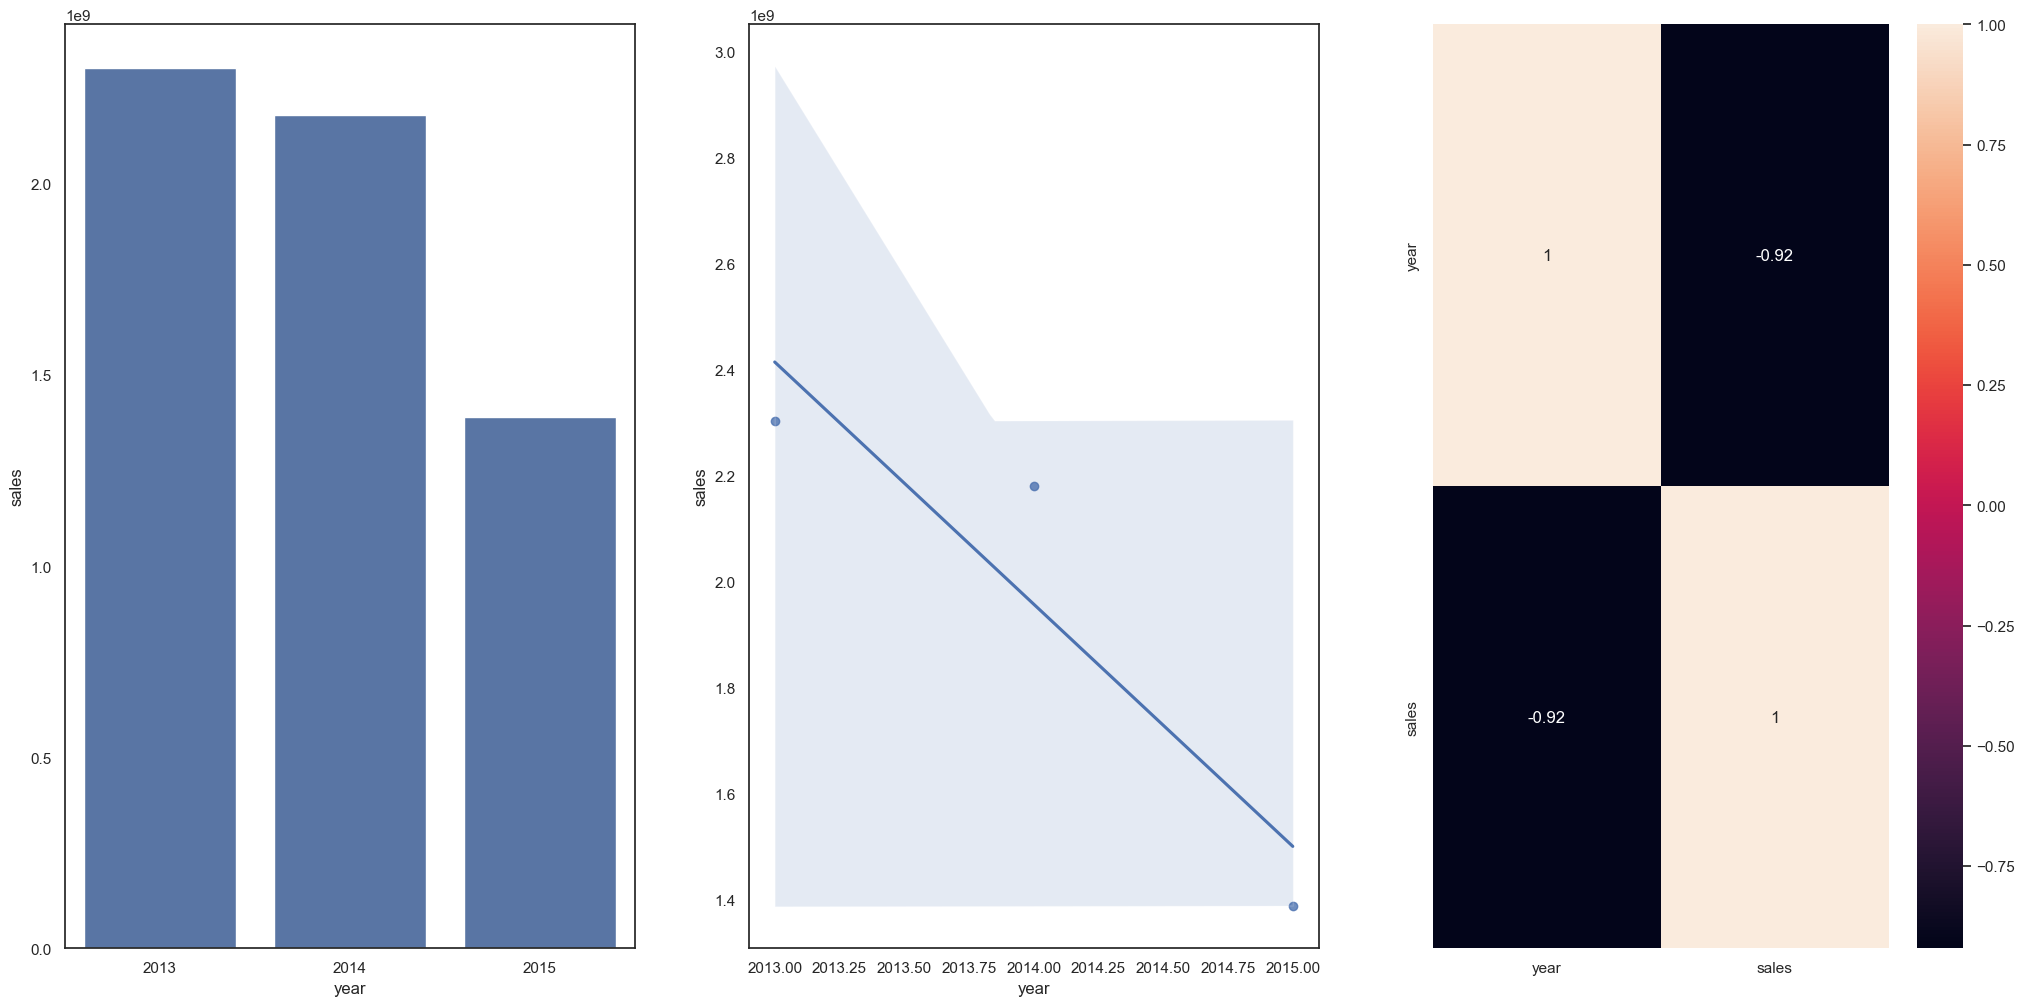

In [61]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H10.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSE** Lojas vemdem menos no segundo semestre do ano.

<Axes: >

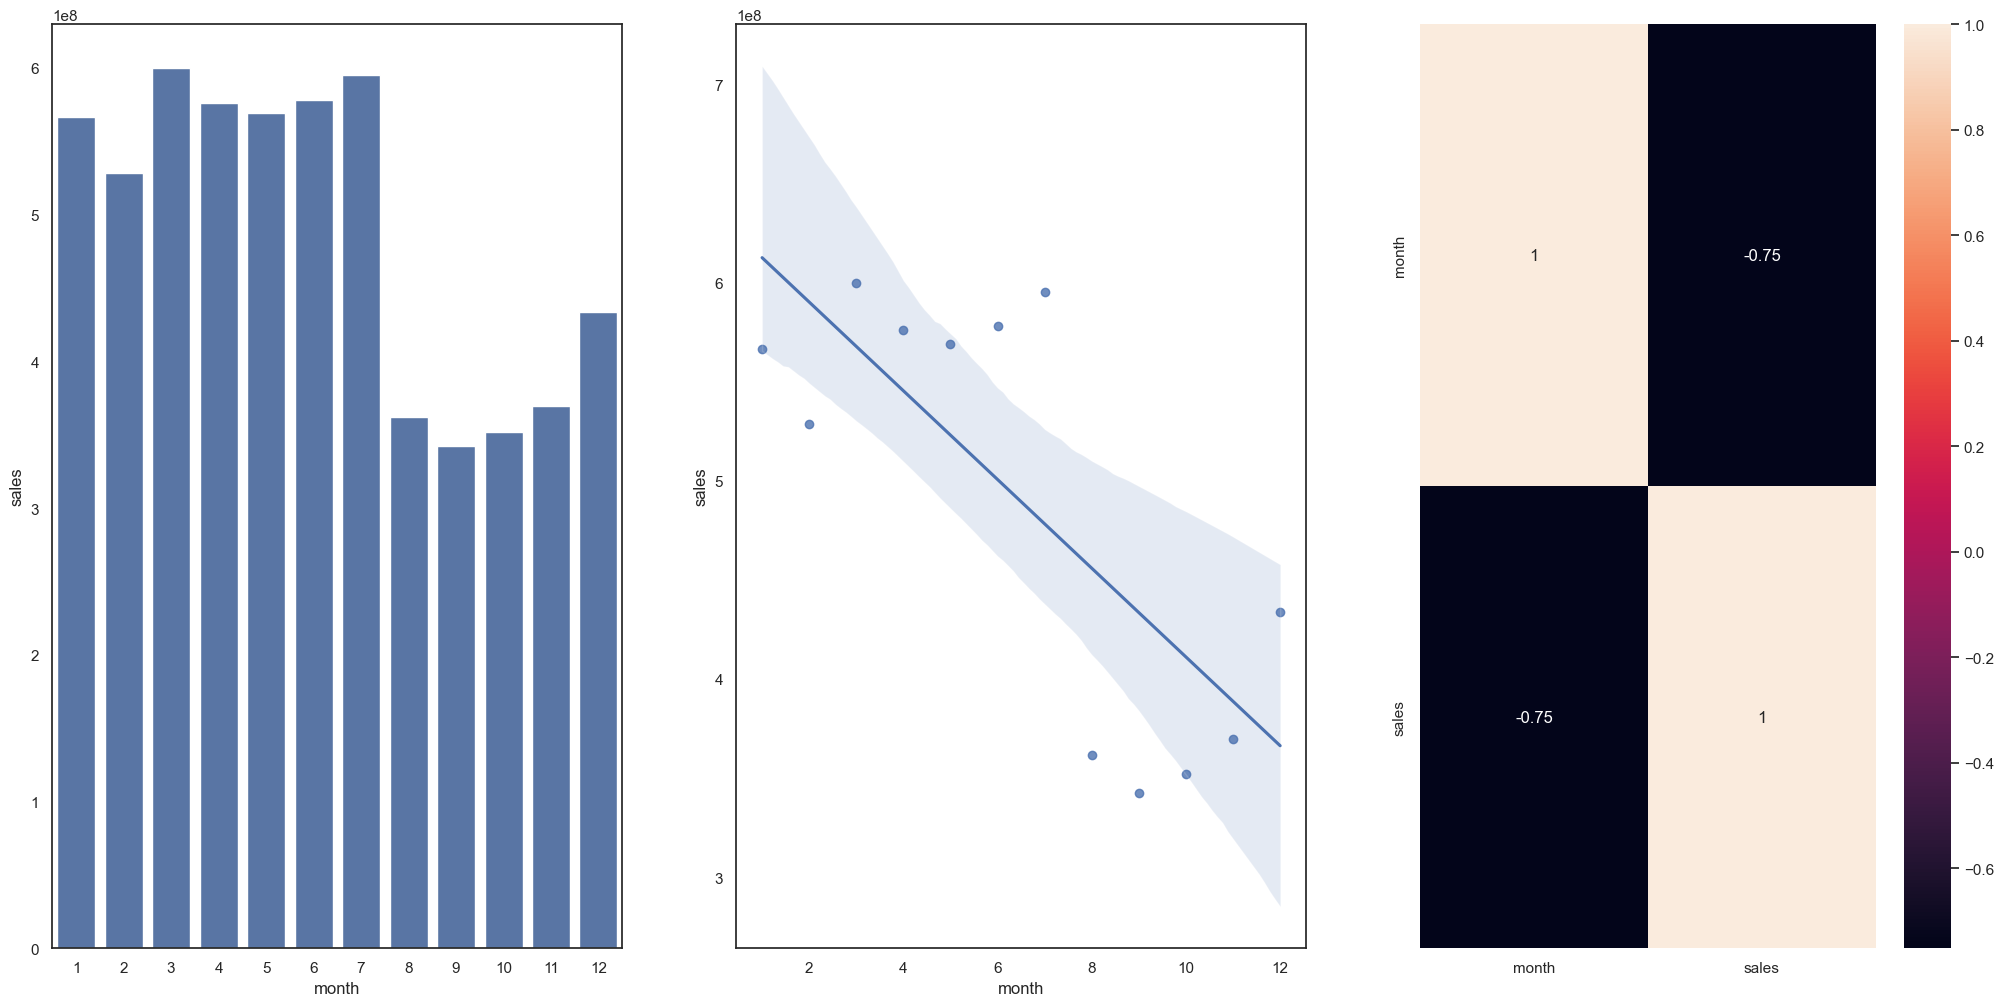

In [62]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês.

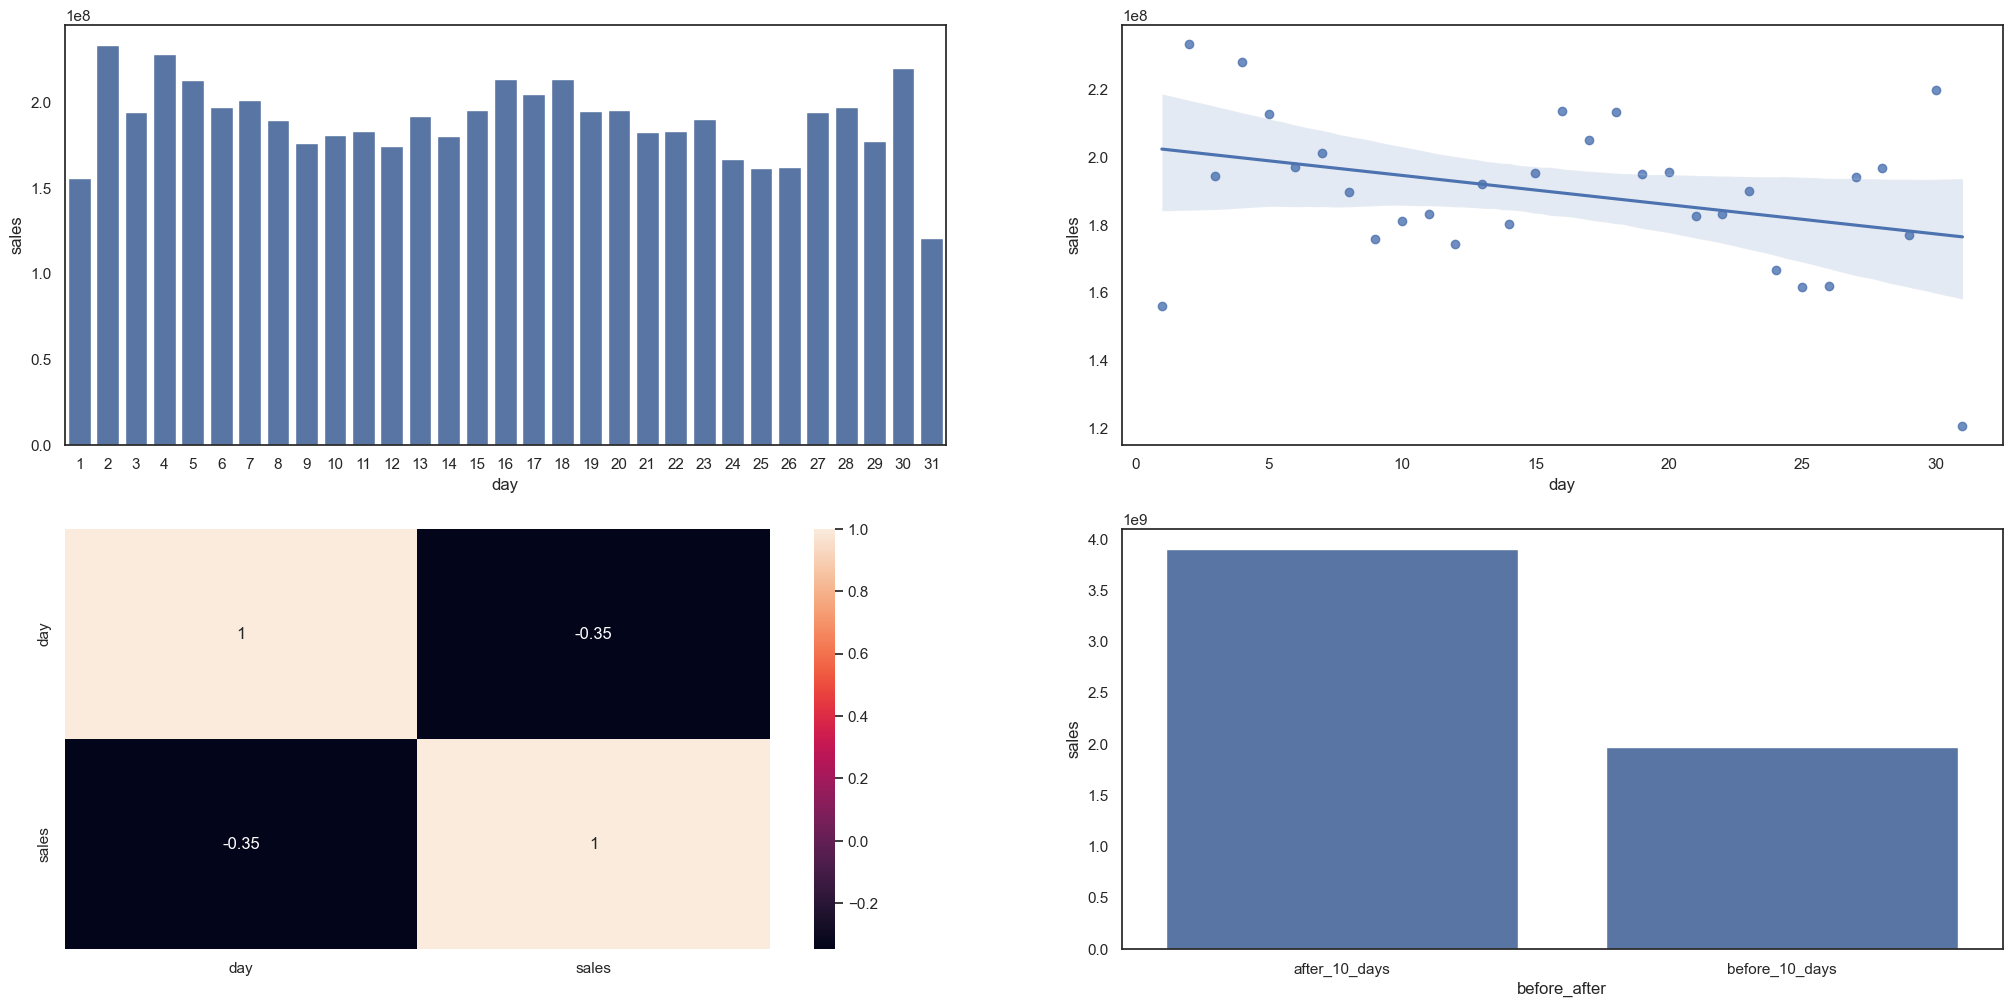

In [63]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

### **H12.** Lojas deveriam vender menos aos finais de semana.
**FALSA** Lojas vendem menos aos finais de semana.

<Axes: >

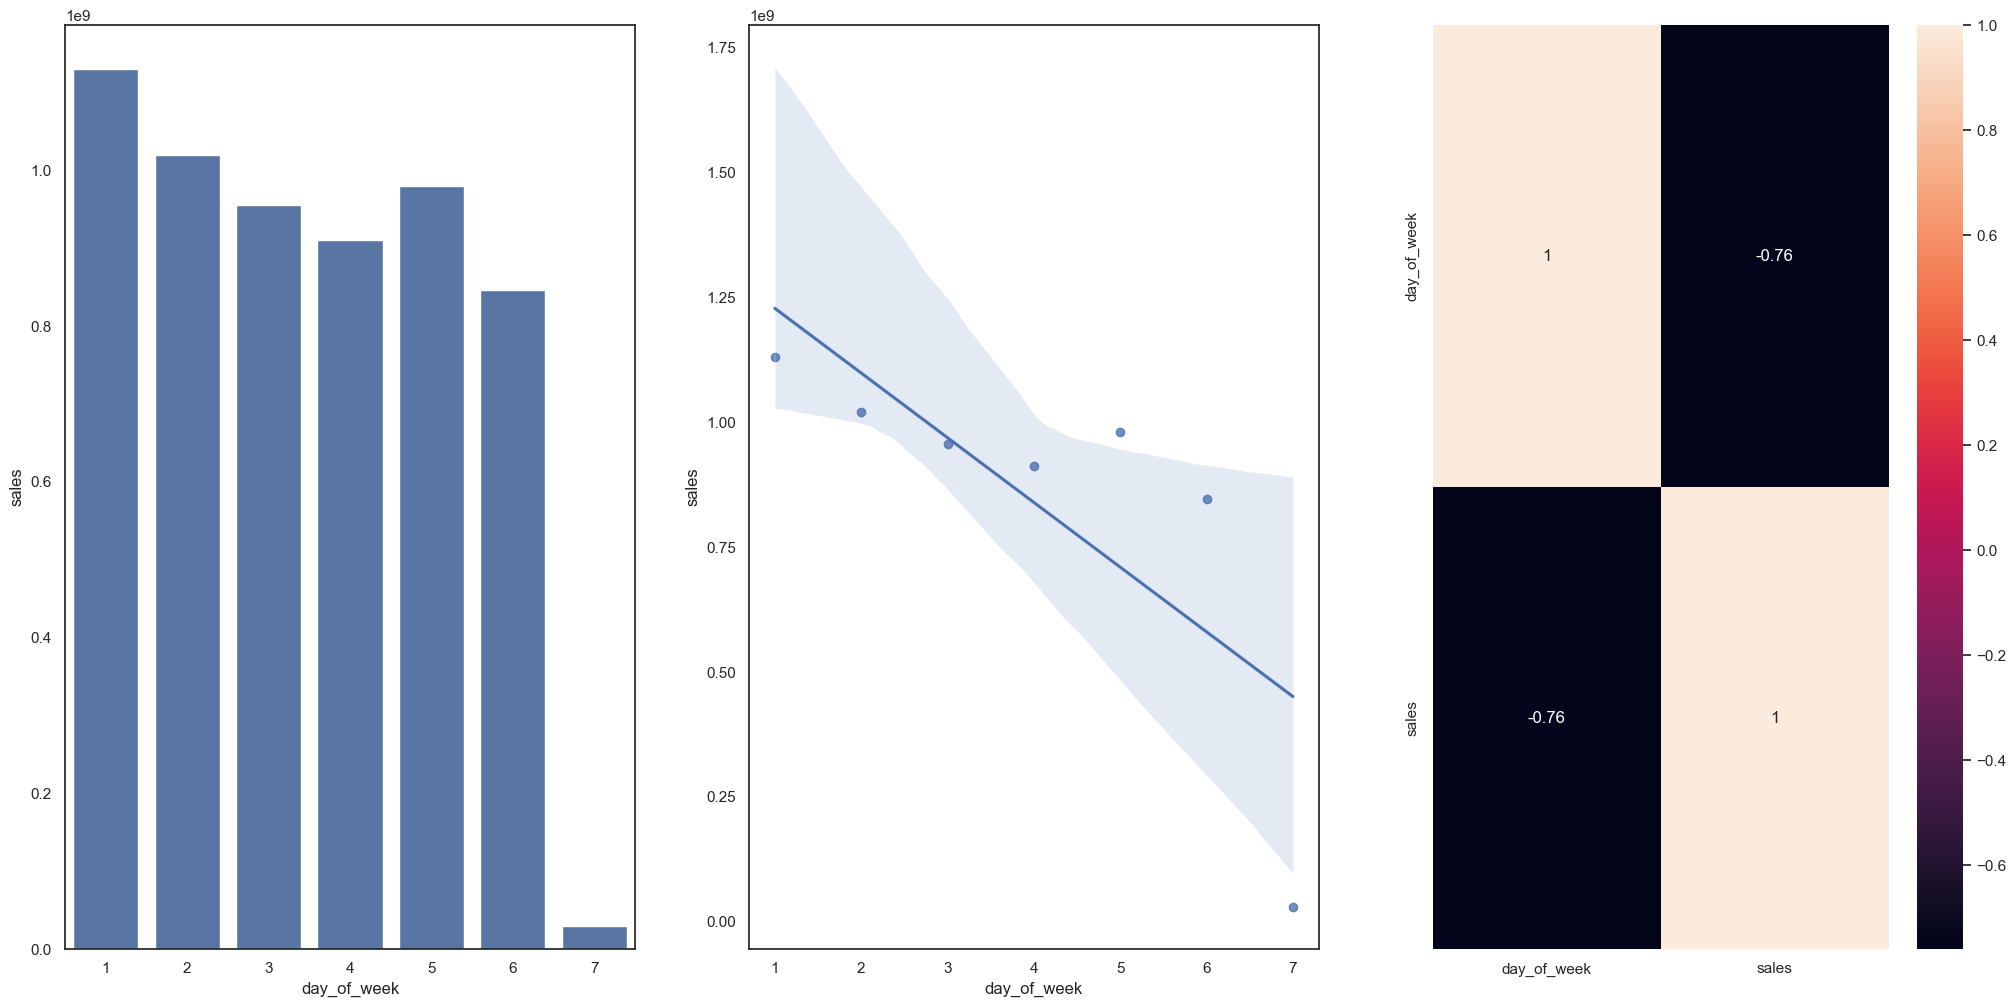

In [64]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H13.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados, exeto nos meses de JUlho e Agosto.

<Axes: xlabel='month', ylabel='sales'>

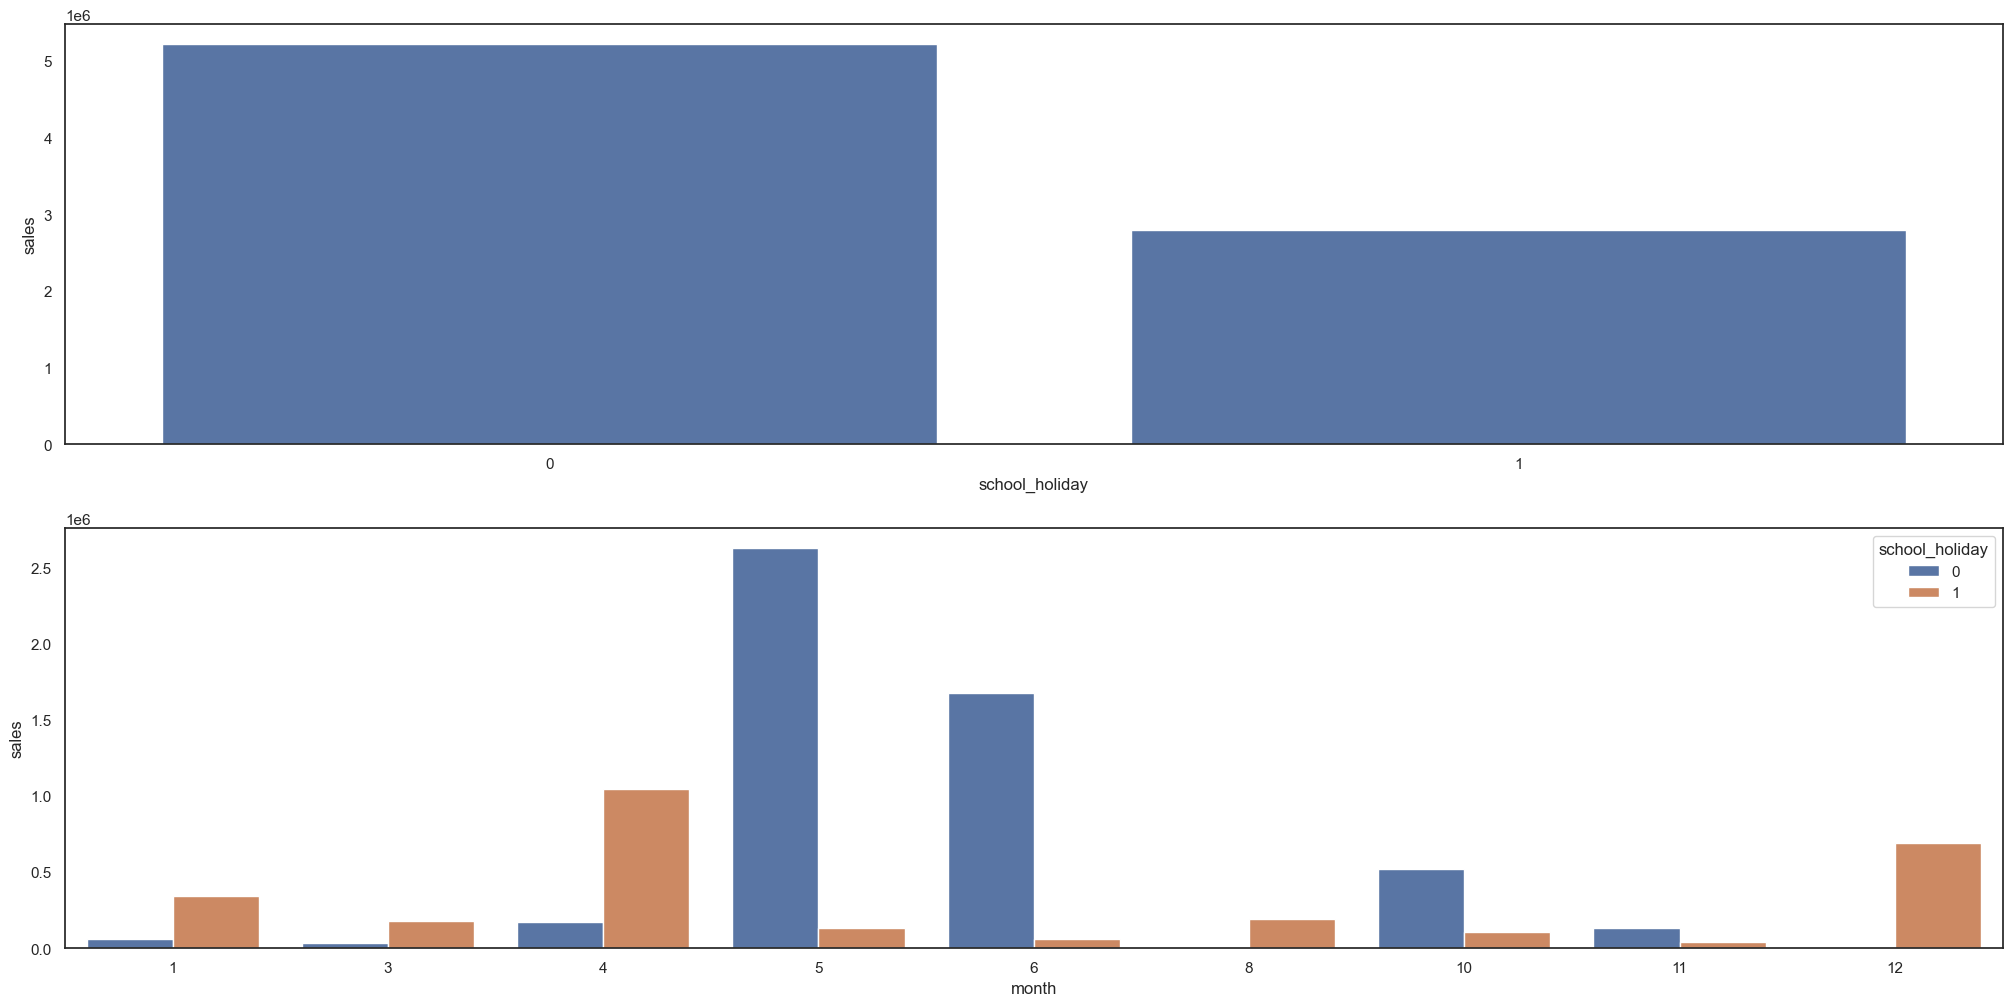

In [65]:
plt.subplot(2, 1, 1)
aux1 = aux[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2, 1, 2)
aux2 = aux[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)

### 4.2.1. Resumo das Hipóteses

In [66]:
from tabulate import tabulate

In [67]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Média'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-',     '-'],
       ['H7', 'Falsa', 'Baixa'],
       ['H8', 'Falsa', 'Média'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Falsa', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Alta'],
       ['H13', 'Verdadeira', 'Baixa']]

print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Média
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

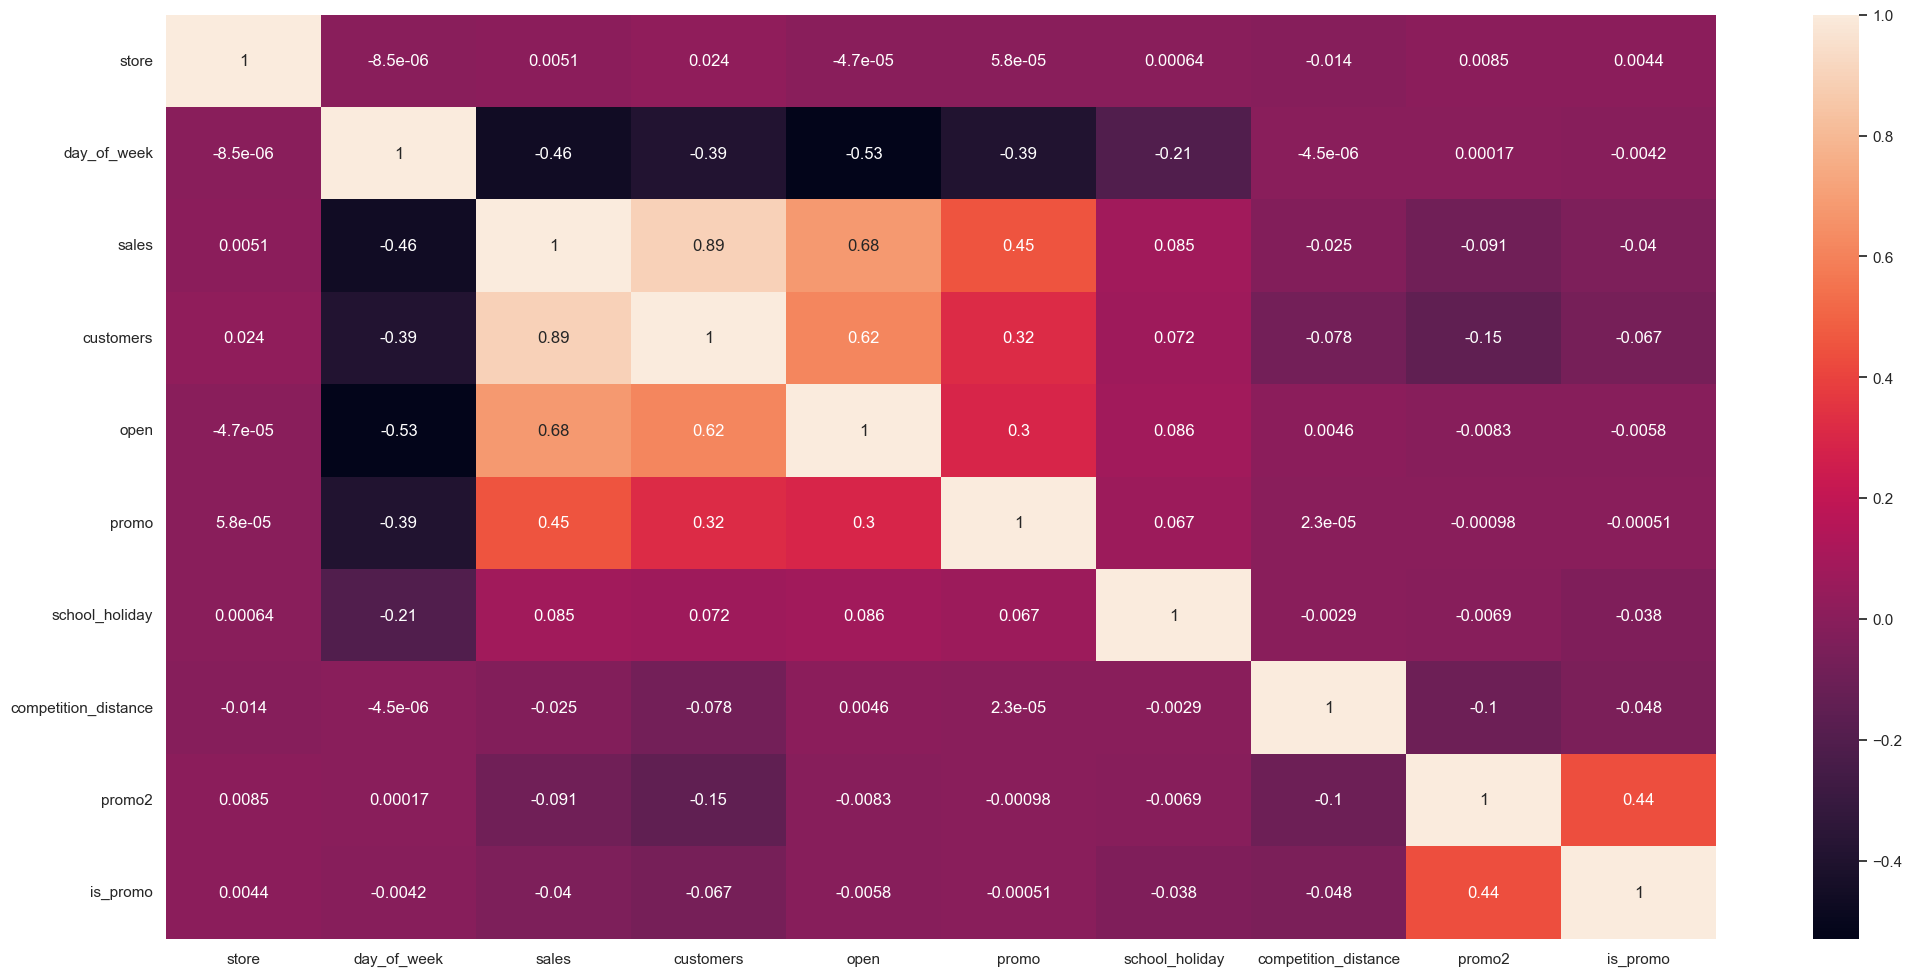

In [68]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );


### 4.3.2. Categorical Attributes

<Axes: >

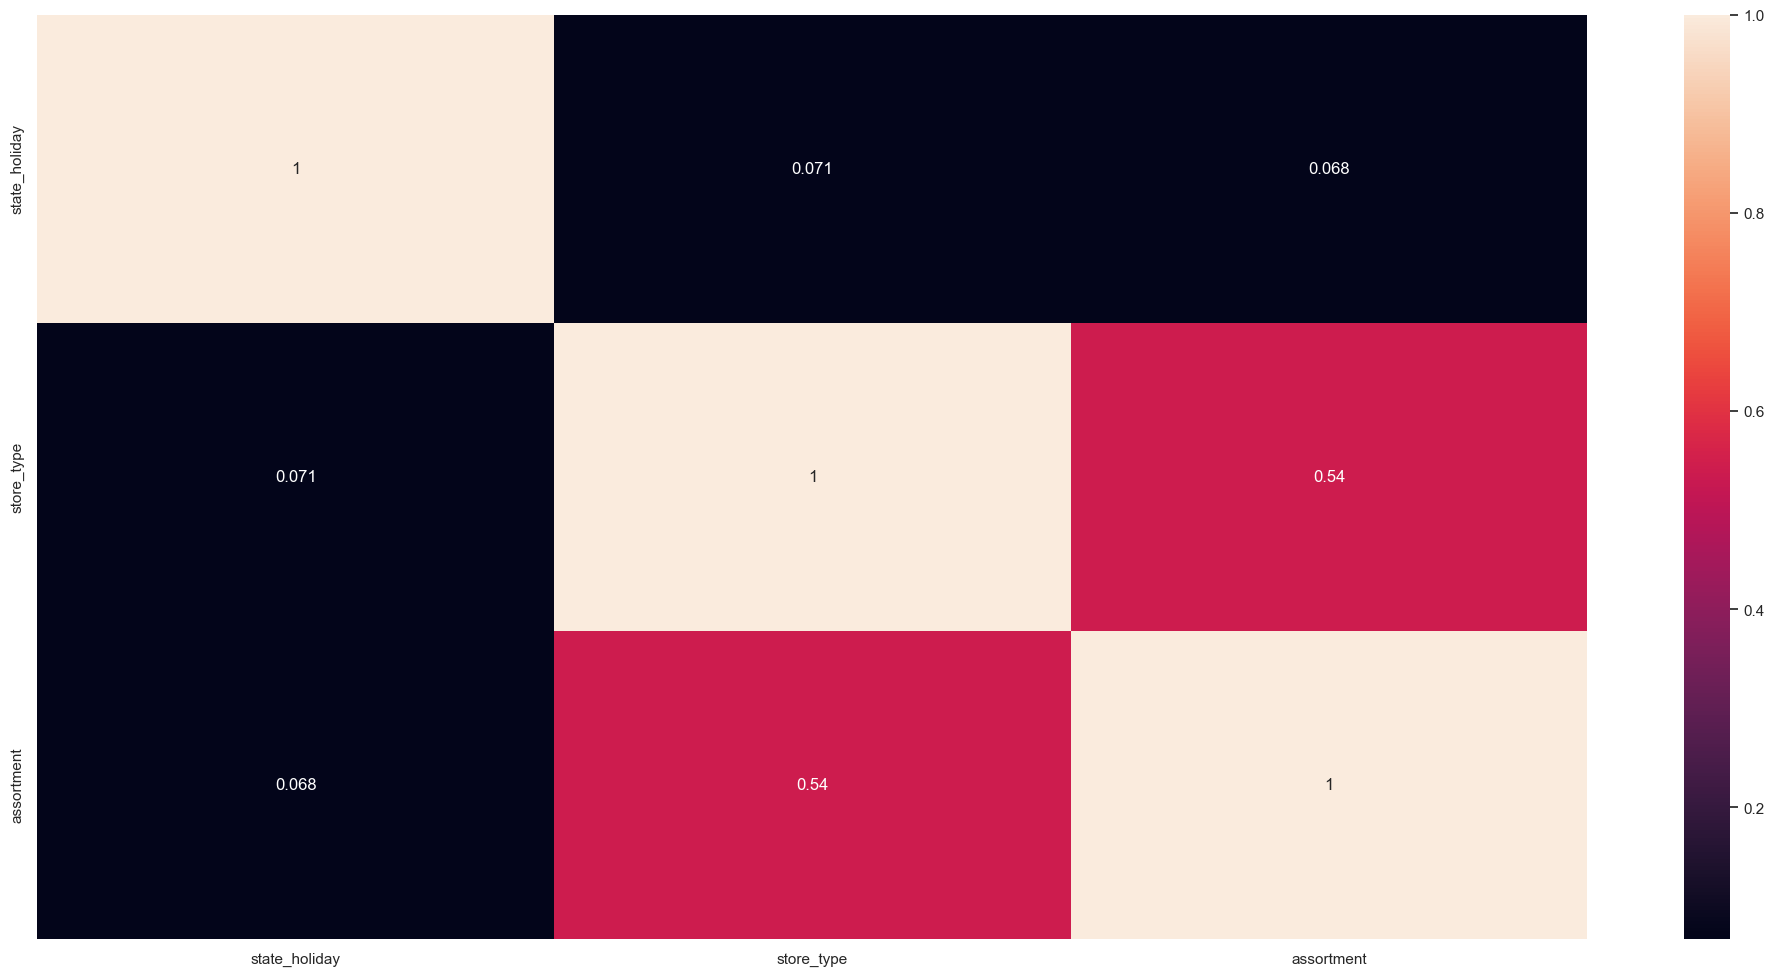

In [69]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])
a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])
a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                   'store_type': [a4, a5, a6],
                   'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# 5.0 Passo 05 - Preparação dos dados

In [70]:
df5 = df4.copy()

## <s>5.1. Normalização</s>

## 5.2. Rescaling

In [71]:
rs = RobustScaler()
mms = MinMaxScaler()

# Competition Distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# Year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(rs, open('parameter/year_scaler.pkl', 'wb'))

# Competition Time Month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# Promo Time Week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl', 'wb'))

## 5.3. Transformação

### 5.3.1. Encoding

In [72]:
# State Holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int)

# Store Types - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# Assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.1. Response Variable Transformation

In [73]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.2. Nature Transformation

In [74]:
# Day of Week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

# Month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

# Day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

# Week of Year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

# 6.0 Passo 06 - Seleção de Atributos

In [75]:
df6 = df5.copy()

## 6.1. Split dataframe into traning and test dataset

In [76]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [77]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [78]:
# Traning dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print(f'Training Min Date: {X_train["date"].min()}')
print(f'Training Max Date: {X_train["date"].max()}')

print(f'\nTraining Min Date: {X_test["date"].min()}')
print(f'Training Max Date: {X_test["date"].max()}')

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Training Min Date: 2015-06-19 00:00:00
Training Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [79]:
#np.int = np.int32
#np.float = np.float64
#np.bool = np.bool_
#
#
## Training and tyest dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#Y_train_n = Y_train.values.ravel()
#
#
## Define RandonForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)
#
## Define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

### 6.2.1. Best Features from Boruta

In [80]:
#cols_selected = boruta.support_.tolist()
#
## Best Features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## Not Selected Boruta
#Xcols_not_selected = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3. Manual Feature Selection

In [81]:
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 
                        'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']


# Columns to add
feat_to_add = ['date', 'sales']

# Final Features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Passo 07 - Modelos de Machine Learning

In [82]:
df7 = df6.copy()

In [83]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Prepation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Avarage Model

In [84]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# Predictions
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# Performace
baseline_result = ml_error('Avarege Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarege Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model

In [85]:
# Model
lr = LinearRegression().fit(x_train, Y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performace
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [86]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularizes Model - Lasso

In [87]:
# Model
lrr = Lasso(alpha=0.01).fit(x_train, Y_train)

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performace
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Lasso - Cross Validation

In [88]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [89]:
# Model
#rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, Y_train)
#
## Prediction
#yhat_rf = rf.predict(x_test)
#
## Performace
#rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
#rf_result

### 7.4.1 Random Forest Regressor - Cross Validation

In [90]:
#rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf)
#rf_result_cv

## 7.5. XGBoost Regressor

In [91]:
# Model 
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, eta=0.1, max_depth=10, subsample=0.7).fit(x_train, Y_train)

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performace
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,805.016209,0.117862,1179.548085


### 7.5.1. XGBoost Regressor - Cross Validation

In [92]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,993.4 +/- 176.31,0.14 +/- 0.02,1431.48 +/- 244.42


## 7.6. Compare Model's Performace

### 7.6.1. Single Performace

In [93]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result,  xgb_result]) #rf_result
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,805.016209,0.117862,1179.548085
0,Avarege Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2. Real Performace- Cross Validation

In [94]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, xgb_result_cv]) # rf_result_cv, 
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,993.4 +/- 176.31,0.14 +/- 0.02,1431.48 +/- 244.42
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8.0 Passo 08 - Hyperparameter Fine Tunning

In [95]:
df8 = df7.copy()

## 8.1. Random Search

In [96]:
#param = {
#    "n_estimators": [1500, 1700, 2500, 3000, 3500], 
#    "eta": [0.01, 0.03], 
#    "max_depth": [3, 5, 9], 
#    "subsample": [0.1, 0.5, 0.7],
#    "colsample_bytree": [0.3, 0.7, 0.9],
#    "min_child_weight": [3, 8, 15]
#    }
#
#MAX_EVAL = 10

In [97]:
#final_result = pd.DataFrame()
#
#for i in range(MAX_EVAL):
#    # Choose values for parameters randoly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
#
#    # Model 
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
#                                 n_estimators=hp['n_estimators'], 
#                                 eta=hp['eta'], 
#                                 max_depth=hp['max_depth'], 
#                                 subsample=hp['subsample'], 
#                                 colsample_bytree=hp['colsample_bytree'], 
#                                 min_child_weight=hp['min_child_weight'])
#
#    # Performace
#    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb)
#    final_result = pd.concat([final_result, result])
#
#final_result

## 8.2. Final Model

In [98]:
param_tuned = {
    "n_estimators": 3000, 
    "eta": 0.03, 
    "max_depth": 5, 
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "min_child_weight": 3
    }

In [99]:
# Model 
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror', 
                                   n_estimators=param_tuned['n_estimators'], 
                                   eta=param_tuned['eta'], max_depth=param_tuned['max_depth'], 
                                   subsample=param_tuned['subsample'], 
                                   colsample_bytree=param_tuned['colsample_bytree'], 
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, Y_train)

# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# Performace
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,775.283909,0.115922,1124.317872


In [100]:
mpe = mean_percentage_error(np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
mpe

-1.5644717613191539

# 9.0 Passo 09 - Tradução e Interpretação do Erro

In [124]:
df9 = X_test[cols_selected_boruta_full]

# Rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

C:\Users\Andre\AppData\Local\Temp\ipykernel_7248\2477857525.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
C:\Users\Andre\AppData\Local\Temp\ipykernel_7248\2477857525.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned)


## 9.1. Business Performance

In [125]:
# Sum of Predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').agg(MAE=('sales', lambda x: mean_absolute_error(x, df9.loc[x.index, 'predictions']))).reset_index()
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').agg(MAPE=('sales', lambda x: mean_absolute_percentage_error(x, df9.loc[x.index, 'predictions']))).reset_index()

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order Columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [130]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105986.109375,102609.171926,109363.046824,3376.937449,0.586957
908,909,221584.546875,213668.261167,229500.832583,7916.285708,0.520840
594,595,307991.250000,302012.283863,313970.216137,5978.966137,0.413208
901,902,198886.031250,197508.246490,200263.816010,1377.784760,0.345097
875,876,194800.671875,190734.989895,198866.353855,4065.681980,0.324211


<Axes: xlabel='store', ylabel='MAPE'>

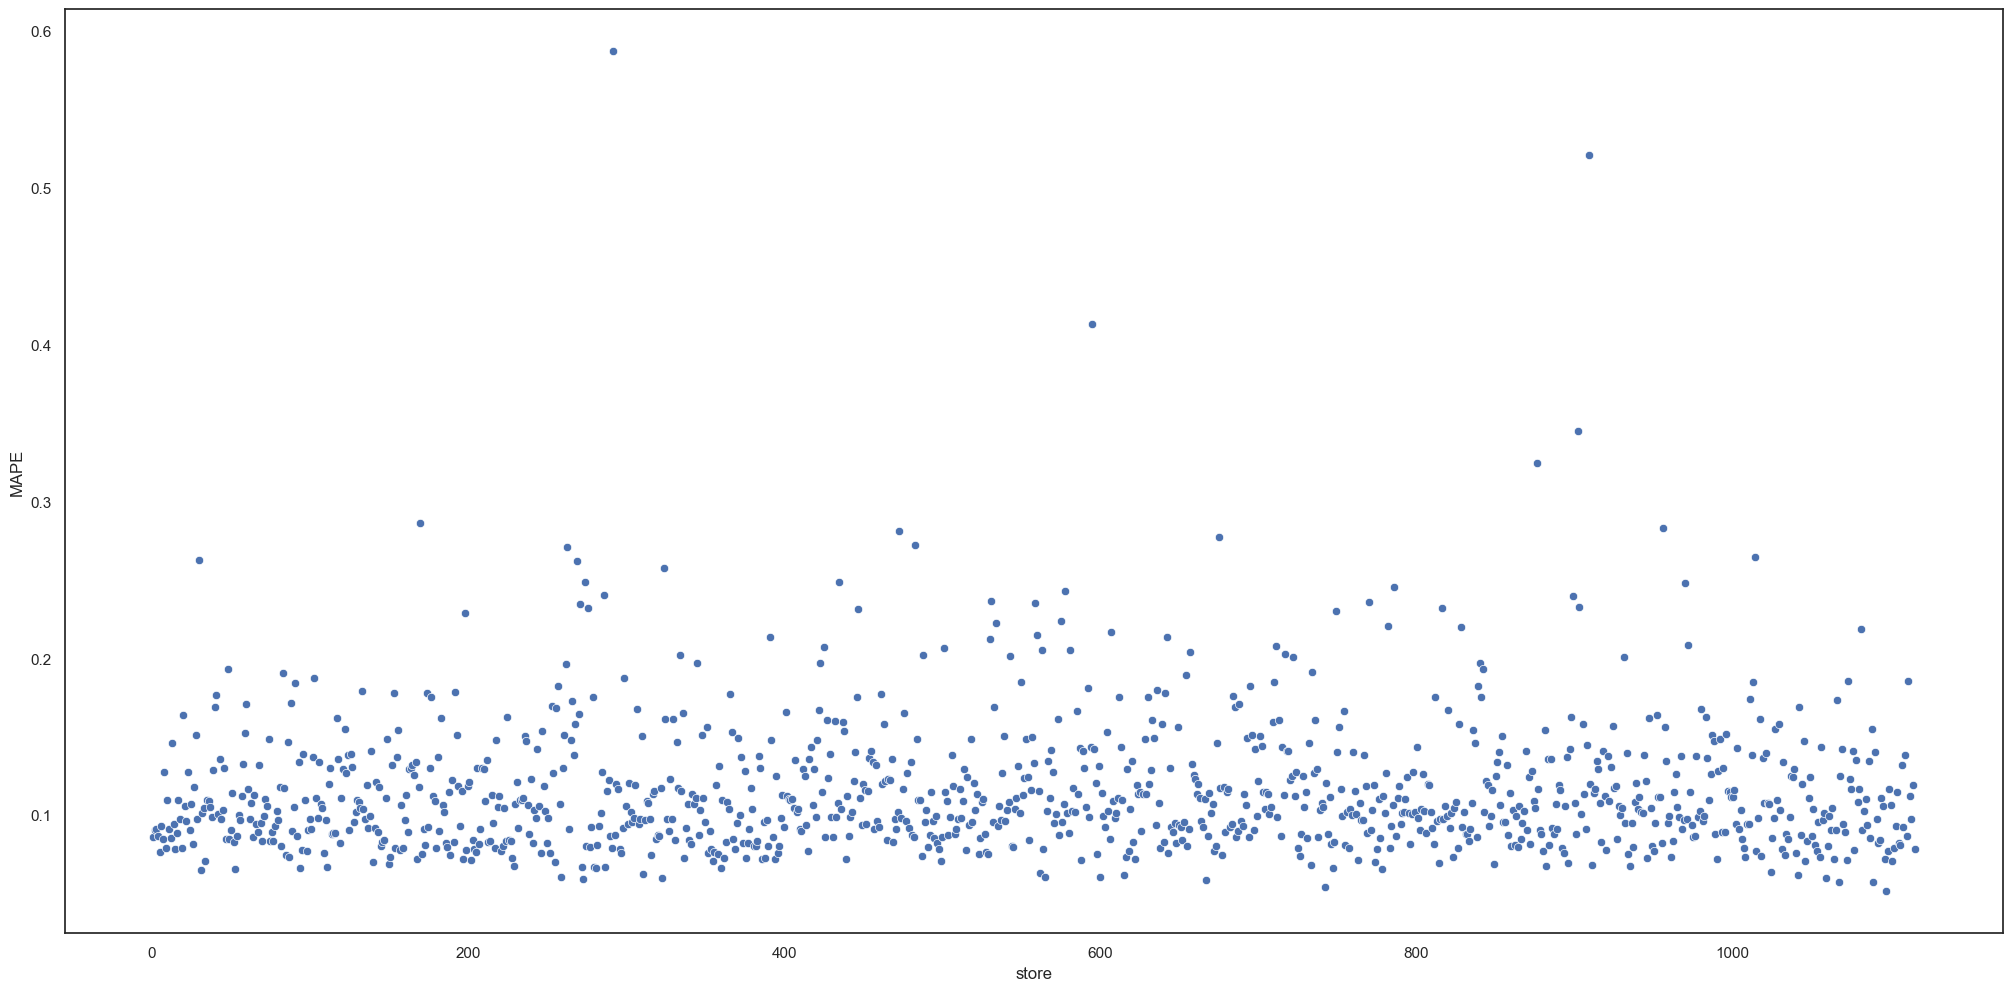

In [127]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2. Total Performance

In [128]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$ 285,819,328.00"
1,worst_scenario,"R$ 284,951,812.74"
2,best_scenario,"R$ 286,686,822.41"


## 9.1. Machine Learning Performance

In [ ]:
df9.loc[:, 'error'] = df9['sales'] - df9['predictions']
df9.loc[:, 'error_rate'] = df9['predictions'] / df9['sales']

C:\Users\Andre\AppData\Local\Temp\ipykernel_15096\3909621883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9.loc[:, 'error'] = df9['sales'] - df9['predictions']
C:\Users\Andre\AppData\Local\Temp\ipykernel_15096\3909621883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9.loc[:, 'error_rate'] = df9['predictions'] / df9['sales']


<Axes: xlabel='predictions', ylabel='error'>

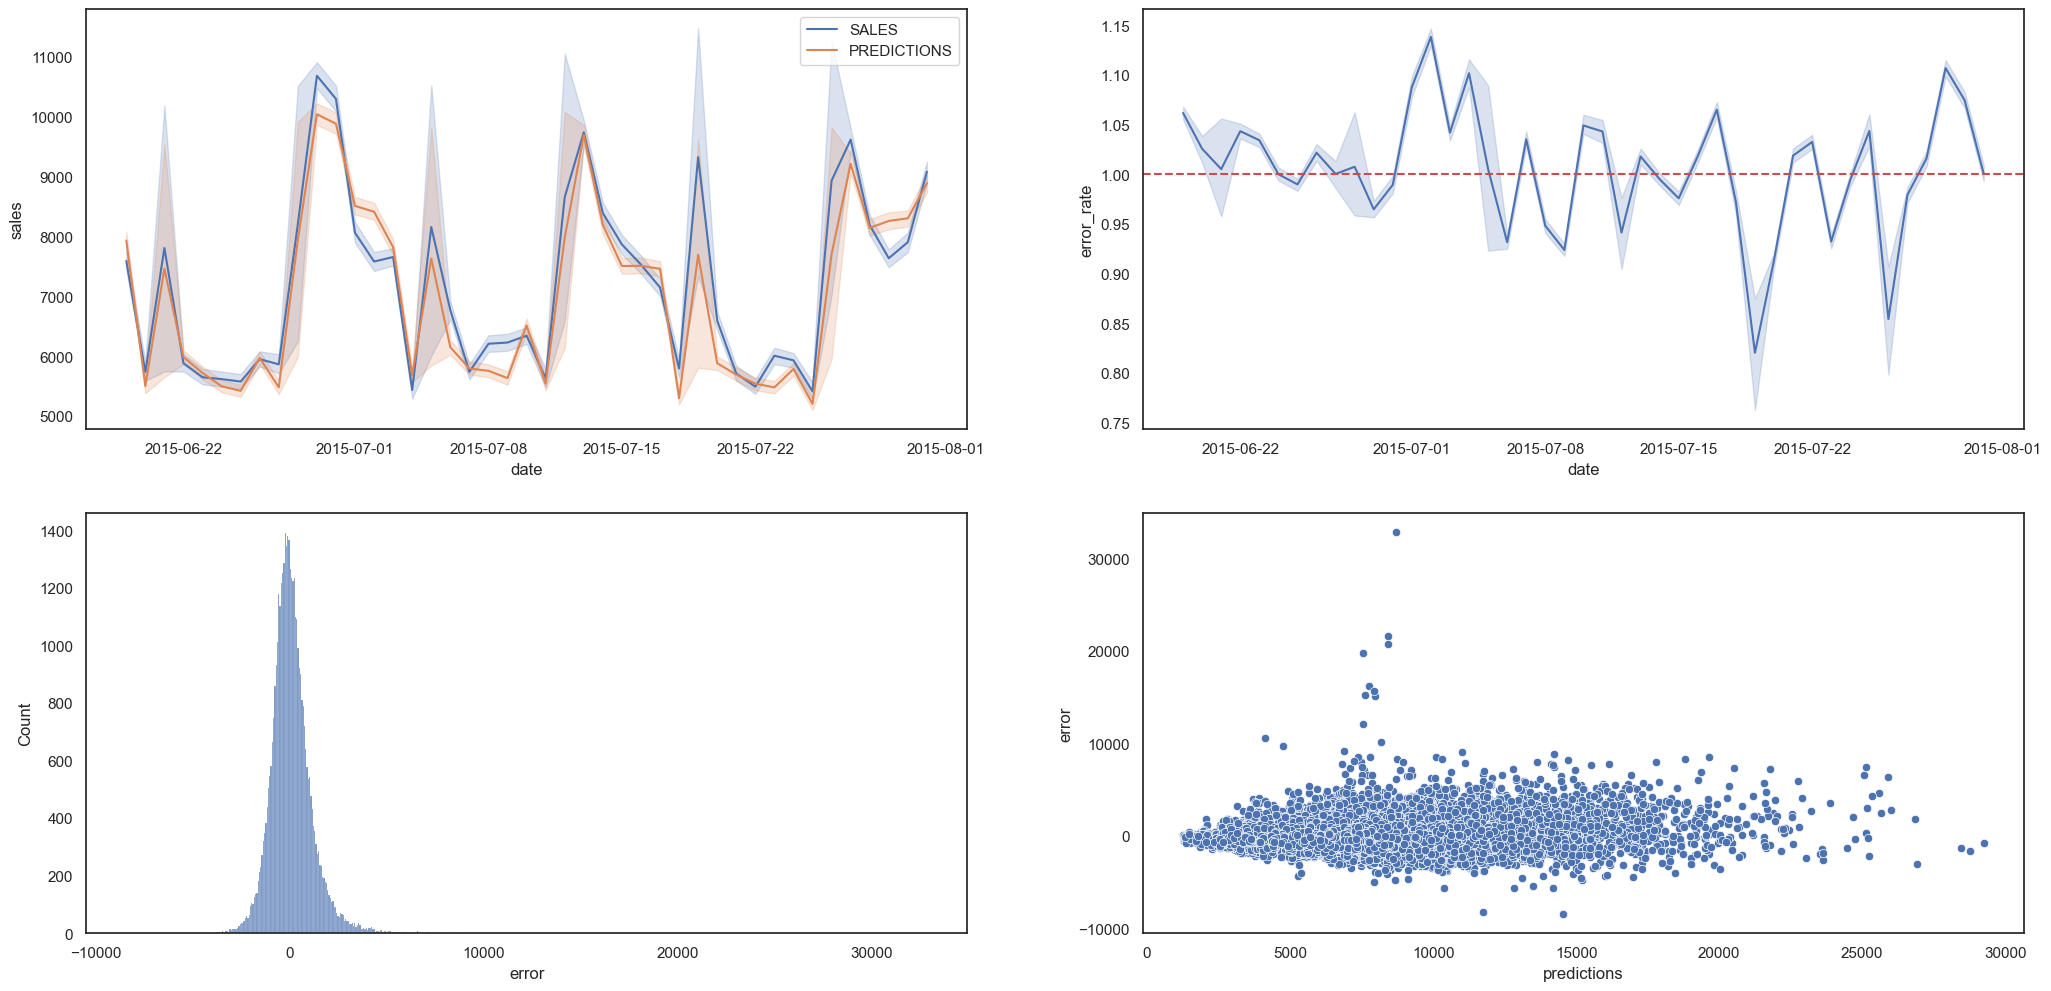

In [ ]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--', color='r')

plt.subplot(2, 2, 3)
sns.histplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(x='predictions', y='error', data=df9)

# 10.0 Passo 10 - Deploy do Modelo em Produção

In [ ]:
# Save Trained Model
pickle.dump(model_xgb_tuned, open(r'C:\Users\Andre\Desktop\DS em Producao\model_rossmann.pkl', 'wb'))

## 10.1 Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):

        self.home_path = r'C:\Users\Andre\Desktop\DS em Producao'
        self.competition_distance_scaler    = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler  = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler         = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                    = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler              = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))

    def data_cleaning(self, df1):
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
                    'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
                    'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))

        # Rename
        df1.columns = cols_new
        
        # Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        # Fillout NA
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'Jun', 6: 'Jul', 7: 'Aug', 8: 'Set', 9: 'Oct', 10: 'Sep', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'] = df1['promo_interval'].fillna(0)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

        # Change Types
        # competition_open_since_month
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

        # competition_open_since_year
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        # promo2_since_week 
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

        # promo2_since_year
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        return df1
    
    def feature_egineering(self, df2):
        ## 2.3. Fearture Engineering
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'] )/7).apply(lambda x: x.days ).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0 Passo 03 - Filtragem de Variáveis
        ## 3.1. Filtragem das Linhas
        df2 = df2[(df2['open'] != 0)]

        ## 3.2. Seleção das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)

        return df2
    
    def data_preparation(self, df5):
        ## 5.2. Rescaling
        # Competition Distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # Competition Time Month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        
        # Promo Time Week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        # Year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ### 5.3.1. Encoding
        # State Holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int)

        # Store Types - Label Encoding
        le = LabelEncoder()
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # Assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.1. Response Variable Transformation
        df5['sales'] = np.log1p(df5['sales'])

        ### 5.3.2. Nature Transformation
        # Day of Week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

        # Month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

        # Day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

        # Week of Year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                                'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 
                                'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):

        # Prediction
        pred = model.predict(test_data)

        # Join pred into the original data
        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Loading Model
model = pickle.load(open(r'C:\Users\Andre\Desktop\DS em Producao\model\model_rossmann.pkl', 'rb'))

# Initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()
    if test_json: # There is data
        if isinstance(test_json, dict): # Unique Example
            teste_raw = pd.DataFrame(test_json, index=[0])
        else: # Multiple Examples
            teste_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
    else:
        return Response('{}', status=200, mimetype='application/json')
    
    # Instantiate Rossman Class
    pipeline = Rossmann()

    # Data Cleaning
    df1 = pipeline.data_cleaning(teste_raw)

    # Feature Engineering
    df2 = pipeline.feature_engineering(df1)

    # Data Preparation
    df3 = pipeline.data_preparation(df2)

    # Prediction
    df_response = pipeline.get_prediction(model, teste_raw, df3)
    return df_response

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [ ]:
import requests

In [ ]:
# Loading test dataset
df10 = pd.read_csv(r'C:\Users\Andre\Desktop\DS em Producao\data\test.csv')

In [ ]:
# Merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# Choose store for prediction
df_test = df_test[df_test['Store'].isin([22, 49, 32, 112, 69, 74, 12, 8, 500, 369, 147, 1000])]

# Remove Closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [ ]:
import json

# Convert Dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [ ]:
# API Call
url = 'https://rossmann-model-test-andre.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print(f'Status Code {r.status_code}')

Status Code 200


In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print(f'Store Number {d2.loc[i, "store"]} will sell R$ {d2.loc[i, "prediction"]:,.2f} in the next 6 weeks')

Store Number 8 will sell R$ 211,962.63 in the next 6 weeks
Store Number 12 will sell R$ 265,252.78 in the next 6 weeks
Store Number 22 will sell R$ 179,193.59 in the next 6 weeks
Store Number 32 will sell R$ 151,379.26 in the next 6 weeks
Store Number 49 will sell R$ 268,043.05 in the next 6 weeks
Store Number 69 will sell R$ 499,420.56 in the next 6 weeks
Store Number 74 will sell R$ 183,881.05 in the next 6 weeks
Store Number 112 will sell R$ 241,621.80 in the next 6 weeks
Store Number 147 will sell R$ 274,724.11 in the next 6 weeks
Store Number 369 will sell R$ 225,190.31 in the next 6 weeks
Store Number 500 will sell R$ 236,613.95 in the next 6 weeks
Store Number 1000 will sell R$ 285,984.09 in the next 6 weeks


In [ ]:
import pandas as pd

# Criando DataFrames
data_esq = {'id_produto': [1], 'max': [2]}
df_esq = pd.DataFrame(data_esq)

data_dir = {'id_produto': [2], 'max': [1]}
df_dir = pd.DataFrame(data_dir)

# Concatenando os DataFrames
df_concatenado = pd.concat([df_esq, df_dir], axis=1)

# Mostrando o DataFrame concatenado

,id_produto,max,id_produto,max
0,1,2,2,1
